##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Human Pose Classification with MoveNet and TensorFlow Lite

This notebook teaches you how to train a pose classification model using MoveNet and TensorFlow Lite. The result is a new TensorFlow Lite model that accepts the output from the MoveNet model as its input, and outputs a pose classification, such as the name of a yoga pose.

The procedure in this notebook consists of 3 parts:
* Part 1: Preprocess the pose classification training data into a CSV file that specifies the landmarks (body keypoints) detected by the MoveNet model, along with the ground truth pose labels.
* Part 2: Build and train a pose classification model that takes the landmark coordinates from the CSV file as input, and outputs the predicted labels.
* Part 3: Convert the pose classification model to TFLite.

By default, this notebook uses an image dataset with labeled yoga poses, but we've also included a section in Part 1 where you can upload your own image dataset of poses.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/pose_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Preparation

In this section, you'll import the necessary libraries and define several functions to preprocess the training images into a CSV file that contains the landmark coordinates and ground truth labels.

Nothing observable happens here, but you can expand the hidden code cells to see the implementation for some of the functions we'll be calling later on.

**If you only want to create the CSV file without knowing all the details, just run this section and proceed to Part 1.**

In [2]:
!pip install -q opencv-python

In [3]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Code to run pose estimation using MoveNet

In [4]:
#@title Functions to run pose estimation with MoveNet

#@markdown You'll download the MoveNet Thunder model from [TensorFlow Hub](https://www.google.com/url?sa=D&q=https%3A%2F%2Ftfhub.dev%2Fs%3Fq%3Dmovenet), and reuse some inference and visualization logic from the [MoveNet Raspberry Pi (Python)](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) sample app to detect landmarks (ear, nose, wrist etc.) from the input images.

#@markdown *Note: You should use the most accurate pose estimation model (i.e. MoveNet Thunder) to detect the keypoints and use them to train the pose classification model to achieve the best accuracy. When running inference, you can use a pose estimation model of your choice (e.g. either MoveNet Lightning or Thunder).*

# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

Cloning into 'examples'...


remote: Enumerating objects: 20873, done.
remote: Counting objects: 100% (2693/2693), done.


remote: Compressing objects: 100% (1209/1209), done.


remote: Total 20873 (delta 1310), reused 2267 (delta 1101), pack-reused 18180
Receiving objects: 100% (20873/20873), 34.22 MiB | 23.67 MiB/s, done.


Resolving deltas: 100% (11404/11404), done.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
#@title Functions to visualize the pose estimation results.

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [6]:
#@title Code to load the images, detect pose landmarks and save them into a CSV file

class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

--2022-03-31 11:09:37--  https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.21.183, 104.18.20.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.21.183|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 21743 (21K) [image/jpeg]
Saving to: ‘/tmp/image.jpeg’

/tmp/image.jpeg     100%[===================>]  21.23K  --.-KB/s    in 0s      

2022-03-31 11:09:37 (87.9 MB/s) - ‘/tmp/image.jpeg’ saved [21743/21743]



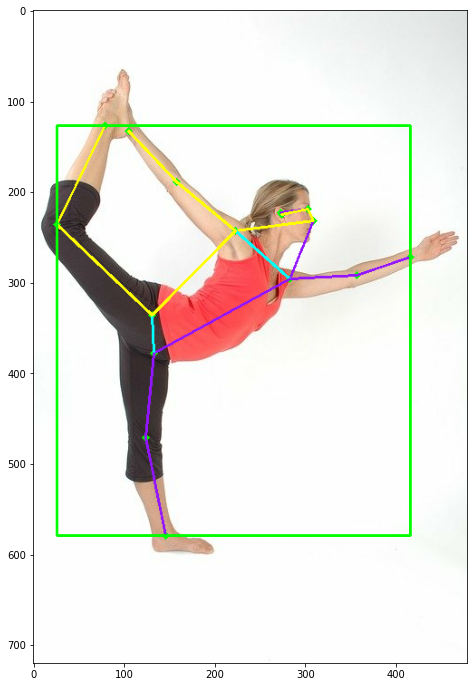

In [7]:
#@title (Optional) Code snippet to try out the Movenet pose estimation logic

#@markdown You can download an image from the internet, run the pose estimation logic on it and plot the detected landmarks on top of the input image. 

#@markdown *Note: This code snippet is also useful for debugging when you encounter an image with bad pose classification accuracy. You can run pose estimation on the image and see if the detected landmarks look correct or not before investigating the pose classification logic.*

test_image_url = "https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg" #@param {type:"string"}
!wget -O /tmp/image.jpeg {test_image_url}

if len(test_image_url):
  image = tf.io.read_file('/tmp/image.jpeg')
  image = tf.io.decode_jpeg(image)
  person = detect(image)
  _ = draw_prediction_on_image(image.numpy(), person, crop_region=None, 
                               close_figure=False, keep_input_size=True)

## Part 1: Preprocess the input images

Because the input for our pose classifier is the *output* landmarks from the MoveNet model, we need to generate our training dataset by running labeled images through MoveNet and then capturing all the landmark data and ground truth labels into a CSV file.

The dataset we've provided for this tutorial is a CG-generated yoga pose dataset. It contains images of multiple CG-generated models doing 5 different yoga poses. The directory is already split into a `train` dataset and a `test` dataset.

So in this section, we'll download the yoga dataset and run it through MoveNet so we can capture all the landmarks into a CSV file... **However, it takes about 15 minutes to feed our yoga dataset to MoveNet and generate this CSV file**. So as an alternative, you can download a pre-existing CSV file for the yoga dataset by setting `is_skip_step_1` parameter below to **True**. That way, you'll skip this step and instead download the same CSV file that will be created in this preprocessing step.

On the other hand, if you want to train the pose classifier with your own image dataset, you need to upload your images and run this preprocessing step (leave `is_skip_step_1` **False**)—follow the instructions below to upload your own pose dataset.

In [8]:
is_skip_step_1 = False #@param ["False", "True"] {type:"raw"}

### (Optional) Upload your own pose dataset

In [9]:
use_custom_dataset = False #@param ["False", "True"] {type:"raw"}

dataset_is_split = False #@param ["False", "True"] {type:"raw"}

If you want to train the pose classifier with your own labeled poses (they can be any poses, not just yoga poses), follow these steps:

1. Set the above `use_custom_dataset` option to **True**.

2. Prepare an archive file (ZIP, TAR, or other) that includes a folder with your images dataset. The folder must include sorted images of your poses as follows.

  If you've already split your dataset into train and test sets, then set `dataset_is_split` to **True**. That is, your images folder must include "train" and "test" directories like this:

    ```
    yoga_poses/
    |__ train/
        |__ downdog/
            |______ 00000128.jpg
            |______ ...
    |__ test/
        |__ downdog/
            |______ 00000181.jpg
            |______ ...
    ```

    Or, if your dataset is NOT split yet, then set
    `dataset_is_split` to **False** and we'll split it up based
    on a specified split fraction. That is, your uploaded images
    folder should look like this:

    ```
    yoga_poses/
    |__ downdog/
        |______ 00000128.jpg
        |______ 00000181.jpg
        |______ ...
    |__ goddess/
        |______ 00000243.jpg
        |______ 00000306.jpg
        |______ ...
    ```
3. Click the **Files** tab on the left (folder icon) and then click **Upload to session storage** (file icon).
4. Select your archive file and wait until it finishes uploading before you proceed.
5. Edit the following code block to specify the name of your archive file and images directory. (By default, we expect a ZIP file, so you'll need to also modify that part if your archive is another format.)
6. Now run the rest of the notebook.

In [10]:
#@markdown Be sure you run this cell. It's hiding the `split_into_train_test()` function that's called in the next code block.

import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):
  """Splits a directory of sorted images into training and test sets.

  Args:
    images_origin: Path to the directory with your images. This directory
      must include subdirectories for each of your labeled classes. For example:
      yoga_poses/
      |__ downdog/
          |______ 00000128.jpg
          |______ 00000181.jpg
          |______ ...
      |__ goddess/
          |______ 00000243.jpg
          |______ 00000306.jpg
          |______ ...
      ...
    images_dest: Path to a directory where you want the split dataset to be
      saved. The results looks like this:
      split_yoga_poses/
      |__ train/
          |__ downdog/
              |______ 00000128.jpg
              |______ ...
      |__ test/
          |__ downdog/
              |______ 00000181.jpg
              |______ ...
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  """
  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [11]:
if use_custom_dataset:
  # ATTENTION:
  # You must edit these two lines to match your archive and images folder name:
  # !tar -xf YOUR_DATASET_ARCHIVE_NAME.tar
  !unzip -q YOUR_DATASET_ARCHIVE_NAME.zip
  dataset_in = 'YOUR_DATASET_DIR_NAME'

  # You can leave the rest alone:
  if not os.path.isdir(dataset_in):
    raise Exception("dataset_in is not a valid directory")
  if dataset_is_split:
    IMAGES_ROOT = dataset_in
  else:
    dataset_out = 'split_' + dataset_in
    split_into_train_test(dataset_in, dataset_out, test_split=0.2)
    IMAGES_ROOT = dataset_out

**Note:** If you're using `split_into_train_test()` to split the dataset, it expects all images to be PNG, JPEG, or BMP—it ignores other file types.

### Download the yoga dataset

In [12]:
if not is_skip_step_1 and not use_custom_dataset:
  !wget -O yoga_poses.zip http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
  !unzip -q yoga_poses.zip -d yoga_cg
  IMAGES_ROOT = "yoga_cg"

--2022-03-31 11:09:46--  http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.126.128, 2a00:1450:4013:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.126.128|:80... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 102517581 (98M) [application/zip]
Saving to: ‘yoga_poses.zip’

yoga_poses.zip        0%[                    ]       0  --.-KB/s               

yoga_poses.zip        4%[                    ]   4.01M  9.22MB/s               

yoga_poses.zip       32%[=====>              ]  32.01M  42.2MB/s               

yoga_poses.zip       65%[============>       ]  64.01M  59.0MB/s               

yoga_poses.zip       90%[=================>  ]  88.01M  66.9MB/s               

yoga_poses.zip      100%[===================>]  97.77M  71.8MB/s    in 1.4s    

2022-03-31 11:09:48 (71.8 MB/s) - ‘yoga_poses.zip’ saved [102517581/102517581]



### Preprocess the `TRAIN` dataset

In [13]:
if not is_skip_step_1:
  images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
  images_out_train_folder = 'poses_images_out_train'
  csvs_out_train_path = 'train_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_train_folder,
      images_out_folder=images_out_train_folder,
      csvs_out_path=csvs_out_train_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing chair


  0%|          | 0/200 [00:00<?, ?it/s]

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:128: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  1%|          | 2/200 [00:00<00:16, 12.37it/s]

  2%|▏         | 4/200 [00:00<00:14, 13.11it/s]

  3%|▎         | 6/200 [00:00<00:14, 13.35it/s]

  4%|▍         | 8/200 [00:00<00:14, 13.52it/s]

  5%|▌         | 10/200 [00:00<00:14, 13.56it/s]

  6%|▌         | 12/200 [00:00<00:13, 13.57it/s]

  7%|▋         | 14/200 [00:01<00:13, 13.59it/s]

  8%|▊         | 16/200 [00:01<00:13, 13.49it/s]

  9%|▉         | 18/200 [00:01<00:13, 13.57it/s]

 10%|█         | 20/200 [00:01<00:13, 13.62it/s]

 11%|█         | 22/200 [00:01<00:13, 13.68it/s]

 12%|█▏        | 24/200 [00:01<00:12, 13.73it/s]

 13%|█▎        | 26/200 [00:01<00:12, 13.73it/s]

 14%|█▍        | 28/200 [00:02<00:12, 13.76it/s]

 15%|█▌        | 30/200 [00:02<00:16, 10.13it/s]

 16%|█▌        | 32/200 [00:02<00:15, 11.01it/s]

 17%|█▋        | 34/200 [00:02<00:14, 11.78it/s]

 18%|█▊        | 36/200 [00:02<00:13, 12.40it/s]

 19%|█▉        | 38/200 [00:02<00:12, 12.80it/s]

 20%|██        | 40/200 [00:03<00:12, 13.07it/s]

 21%|██        | 42/200 [00:03<00:11, 13.24it/s]

 22%|██▏       | 44/200 [00:03<00:11, 13.33it/s]

 23%|██▎       | 46/200 [00:03<00:11, 13.48it/s]

 24%|██▍       | 48/200 [00:03<00:11, 13.41it/s]

 25%|██▌       | 50/200 [00:03<00:11, 13.38it/s]

 26%|██▌       | 52/200 [00:03<00:11, 13.39it/s]

 27%|██▋       | 54/200 [00:04<00:10, 13.37it/s]

 28%|██▊       | 56/200 [00:04<00:10, 13.42it/s]

 29%|██▉       | 58/200 [00:04<00:10, 13.54it/s]

 30%|███       | 60/200 [00:04<00:10, 13.57it/s]

 31%|███       | 62/200 [00:04<00:10, 13.60it/s]

 32%|███▏      | 64/200 [00:04<00:09, 13.66it/s]

 33%|███▎      | 66/200 [00:05<00:09, 13.68it/s]

 34%|███▍      | 68/200 [00:05<00:09, 13.68it/s]

 35%|███▌      | 70/200 [00:05<00:09, 13.65it/s]

 36%|███▌      | 72/200 [00:05<00:09, 13.65it/s]

 37%|███▋      | 74/200 [00:05<00:09, 13.69it/s]

 38%|███▊      | 76/200 [00:05<00:12,  9.91it/s]

 39%|███▉      | 78/200 [00:06<00:11, 10.81it/s]

 40%|████      | 80/200 [00:06<00:10, 11.55it/s]

 41%|████      | 82/200 [00:06<00:09, 12.14it/s]

 42%|████▏     | 84/200 [00:06<00:09, 12.57it/s]

 43%|████▎     | 86/200 [00:06<00:08, 12.86it/s]

 44%|████▍     | 88/200 [00:06<00:07, 14.07it/s]

 45%|████▌     | 90/200 [00:06<00:07, 15.16it/s]

 46%|████▌     | 92/200 [00:07<00:07, 15.28it/s]

 47%|████▋     | 94/200 [00:07<00:06, 16.10it/s]

 48%|████▊     | 96/200 [00:07<00:06, 16.81it/s]

 49%|████▉     | 98/200 [00:07<00:06, 16.59it/s]

 50%|█████     | 100/200 [00:07<00:06, 16.34it/s]

 51%|█████     | 102/200 [00:07<00:05, 16.99it/s]

 52%|█████▏    | 104/200 [00:07<00:05, 17.46it/s]

 53%|█████▎    | 106/200 [00:07<00:05, 17.80it/s]

 54%|█████▍    | 108/200 [00:07<00:05, 17.99it/s]

 55%|█████▌    | 110/200 [00:08<00:04, 18.13it/s]

 56%|█████▌    | 112/200 [00:08<00:04, 18.21it/s]

 57%|█████▋    | 114/200 [00:08<00:04, 18.37it/s]

 58%|█████▊    | 116/200 [00:08<00:05, 16.64it/s]

 59%|█████▉    | 118/200 [00:08<00:05, 16.35it/s]

 60%|██████    | 120/200 [00:08<00:05, 15.29it/s]

 61%|██████    | 122/200 [00:08<00:05, 14.76it/s]

 62%|██████▏   | 124/200 [00:08<00:05, 14.35it/s]

 63%|██████▎   | 126/200 [00:09<00:05, 14.11it/s]

 64%|██████▍   | 128/200 [00:09<00:05, 13.83it/s]

 65%|██████▌   | 130/200 [00:09<00:05, 13.68it/s]

 66%|██████▌   | 132/200 [00:09<00:04, 14.10it/s]

 67%|██████▋   | 134/200 [00:09<00:04, 13.83it/s]

 68%|██████▊   | 136/200 [00:09<00:04, 13.64it/s]

 69%|██████▉   | 138/200 [00:09<00:04, 13.52it/s]

 70%|███████   | 140/200 [00:10<00:04, 13.45it/s]

 71%|███████   | 142/200 [00:10<00:04, 13.45it/s]

 72%|███████▏  | 144/200 [00:10<00:04, 13.38it/s]

 73%|███████▎  | 146/200 [00:10<00:04, 13.28it/s]

 74%|███████▍  | 148/200 [00:10<00:03, 13.36it/s]

 75%|███████▌  | 150/200 [00:10<00:03, 13.14it/s]

 76%|███████▌  | 152/200 [00:11<00:03, 13.15it/s]

 77%|███████▋  | 154/200 [00:11<00:03, 13.75it/s]

 78%|███████▊  | 156/200 [00:11<00:03, 14.24it/s]

 79%|███████▉  | 158/200 [00:11<00:02, 15.24it/s]

 80%|████████  | 160/200 [00:11<00:02, 16.06it/s]

 81%|████████  | 162/200 [00:11<00:02, 15.21it/s]

 82%|████████▏ | 164/200 [00:11<00:02, 14.58it/s]

 83%|████████▎ | 166/200 [00:12<00:03,  9.28it/s]

 84%|████████▍ | 168/200 [00:12<00:03, 10.21it/s]

 85%|████████▌ | 170/200 [00:12<00:02, 10.96it/s]

 86%|████████▌ | 172/200 [00:12<00:02, 11.62it/s]

 87%|████████▋ | 174/200 [00:12<00:02, 12.08it/s]

 88%|████████▊ | 176/200 [00:12<00:01, 12.47it/s]

 89%|████████▉ | 178/200 [00:13<00:01, 12.47it/s]

 90%|█████████ | 180/200 [00:13<00:01, 12.72it/s]

 91%|█████████ | 182/200 [00:13<00:01, 12.85it/s]

 92%|█████████▏| 184/200 [00:13<00:01, 12.97it/s]

 93%|█████████▎| 186/200 [00:13<00:01, 13.14it/s]

 94%|█████████▍| 188/200 [00:13<00:00, 13.28it/s]

 95%|█████████▌| 190/200 [00:14<00:00, 13.21it/s]

 96%|█████████▌| 192/200 [00:14<00:00, 13.20it/s]

 97%|█████████▋| 194/200 [00:14<00:00, 13.25it/s]

 98%|█████████▊| 196/200 [00:14<00:00, 13.32it/s]

 99%|█████████▉| 198/200 [00:14<00:00, 13.45it/s]

100%|██████████| 200/200 [00:14<00:00, 13.40it/s]

100%|██████████| 200/200 [00:14<00:00, 13.54it/s]


Preprocessing cobra


  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:00<00:10, 18.22it/s]

  2%|▏         | 4/200 [00:00<00:10, 18.00it/s]

  3%|▎         | 6/200 [00:00<00:10, 17.96it/s]

  4%|▍         | 8/200 [00:00<00:10, 18.05it/s]

  5%|▌         | 10/200 [00:00<00:10, 17.85it/s]

  6%|▌         | 12/200 [00:00<00:10, 17.67it/s]

  7%|▋         | 14/200 [00:00<00:10, 17.56it/s]

  8%|▊         | 16/200 [00:00<00:11, 15.78it/s]

  9%|▉         | 18/200 [00:01<00:11, 16.37it/s]

 10%|█         | 20/200 [00:01<00:10, 16.81it/s]

 11%|█         | 22/200 [00:01<00:10, 17.15it/s]

 12%|█▏        | 24/200 [00:01<00:10, 17.36it/s]

 13%|█▎        | 26/200 [00:01<00:09, 17.59it/s]

 14%|█▍        | 28/200 [00:01<00:09, 17.67it/s]

 15%|█▌        | 30/200 [00:01<00:09, 17.69it/s]

 16%|█▌        | 32/200 [00:01<00:09, 17.73it/s]

 17%|█▋        | 34/200 [00:01<00:09, 17.72it/s]

 18%|█▊        | 36/200 [00:02<00:09, 17.77it/s]

 19%|█▉        | 38/200 [00:02<00:09, 16.91it/s]

 20%|██        | 40/200 [00:02<00:09, 16.36it/s]

 21%|██        | 42/200 [00:02<00:10, 15.36it/s]

 22%|██▏       | 44/200 [00:02<00:10, 14.82it/s]

 23%|██▎       | 46/200 [00:02<00:10, 14.47it/s]

 24%|██▍       | 48/200 [00:02<00:10, 14.86it/s]

 25%|██▌       | 50/200 [00:03<00:09, 15.22it/s]

 26%|██▌       | 52/200 [00:03<00:09, 15.44it/s]

 27%|██▋       | 54/200 [00:03<00:09, 14.97it/s]

 28%|██▊       | 56/200 [00:03<00:09, 14.61it/s]

 29%|██▉       | 58/200 [00:03<00:09, 14.32it/s]

 30%|███       | 60/200 [00:03<00:09, 14.12it/s]

 31%|███       | 62/200 [00:03<00:09, 14.04it/s]

 32%|███▏      | 64/200 [00:04<00:09, 13.82it/s]

 33%|███▎      | 66/200 [00:04<00:09, 13.71it/s]

 34%|███▍      | 68/200 [00:04<00:09, 13.53it/s]

 35%|███▌      | 70/200 [00:04<00:09, 13.97it/s]

 36%|███▌      | 72/200 [00:04<00:08, 14.30it/s]

 37%|███▋      | 74/200 [00:04<00:09, 13.82it/s]

 38%|███▊      | 76/200 [00:04<00:08, 14.12it/s]

 39%|███▉      | 78/200 [00:05<00:08, 14.48it/s]

 40%|████      | 80/200 [00:05<00:07, 15.40it/s]

 41%|████      | 82/200 [00:05<00:07, 16.07it/s]

 42%|████▏     | 84/200 [00:05<00:07, 16.50it/s]

 43%|████▎     | 86/200 [00:05<00:06, 16.94it/s]

 44%|████▍     | 88/200 [00:05<00:06, 17.24it/s]

 45%|████▌     | 90/200 [00:06<00:12,  9.14it/s]

 46%|████▌     | 92/200 [00:06<00:10, 10.39it/s]

 47%|████▋     | 94/200 [00:06<00:09, 11.75it/s]

 48%|████▊     | 96/200 [00:06<00:07, 13.15it/s]

 49%|████▉     | 98/200 [00:06<00:07, 14.34it/s]

 50%|█████     | 100/200 [00:06<00:06, 14.86it/s]

 51%|█████     | 102/200 [00:06<00:06, 15.05it/s]

 52%|█████▏    | 104/200 [00:06<00:06, 15.14it/s]

 53%|█████▎    | 106/200 [00:07<00:06, 15.16it/s]

 54%|█████▍    | 108/200 [00:07<00:06, 14.58it/s]

 55%|█████▌    | 110/200 [00:07<00:06, 14.16it/s]

 56%|█████▌    | 112/200 [00:07<00:06, 13.92it/s]

 57%|█████▋    | 114/200 [00:07<00:06, 14.29it/s]

 58%|█████▊    | 116/200 [00:07<00:05, 15.22it/s]

 59%|█████▉    | 118/200 [00:07<00:05, 16.05it/s]

 60%|██████    | 120/200 [00:07<00:05, 15.18it/s]

 61%|██████    | 122/200 [00:08<00:05, 14.56it/s]

 62%|██████▏   | 124/200 [00:08<00:05, 14.18it/s]

 63%|██████▎   | 126/200 [00:08<00:05, 13.90it/s]

 64%|██████▍   | 128/200 [00:08<00:05, 13.62it/s]

 65%|██████▌   | 130/200 [00:08<00:05, 13.55it/s]

 66%|██████▌   | 132/200 [00:08<00:05, 13.52it/s]

 67%|██████▋   | 134/200 [00:09<00:04, 13.51it/s]

 68%|██████▊   | 136/200 [00:09<00:04, 13.49it/s]

 69%|██████▉   | 138/200 [00:09<00:04, 13.38it/s]

 70%|███████   | 140/200 [00:09<00:04, 13.52it/s]

 71%|███████   | 142/200 [00:09<00:04, 13.46it/s]

 72%|███████▏  | 144/200 [00:09<00:04, 13.46it/s]

 73%|███████▎  | 146/200 [00:09<00:04, 13.50it/s]

 74%|███████▍  | 148/200 [00:10<00:03, 13.50it/s]

 75%|███████▌  | 150/200 [00:10<00:03, 13.56it/s]

 76%|███████▌  | 152/200 [00:10<00:03, 13.54it/s]

 77%|███████▋  | 154/200 [00:10<00:03, 13.46it/s]

 78%|███████▊  | 156/200 [00:10<00:03, 13.37it/s]

 79%|███████▉  | 158/200 [00:10<00:03, 13.38it/s]

 80%|████████  | 160/200 [00:10<00:02, 13.92it/s]

 81%|████████  | 162/200 [00:11<00:02, 13.81it/s]

 82%|████████▏ | 164/200 [00:11<00:02, 14.26it/s]

 83%|████████▎ | 166/200 [00:11<00:02, 15.27it/s]

 84%|████████▍ | 168/200 [00:11<00:02, 14.76it/s]

 85%|████████▌ | 170/200 [00:11<00:02, 14.97it/s]

 86%|████████▌ | 172/200 [00:11<00:01, 15.13it/s]

 87%|████████▋ | 174/200 [00:11<00:01, 15.91it/s]

 88%|████████▊ | 176/200 [00:11<00:01, 16.43it/s]

 89%|████████▉ | 178/200 [00:12<00:01, 16.84it/s]

 90%|█████████ | 180/200 [00:12<00:01, 16.41it/s]

 91%|█████████ | 182/200 [00:12<00:01, 15.29it/s]

 92%|█████████▏| 184/200 [00:12<00:01, 14.75it/s]

 93%|█████████▎| 186/200 [00:12<00:00, 14.90it/s]

 94%|█████████▍| 188/200 [00:12<00:00, 15.74it/s]

 95%|█████████▌| 190/200 [00:12<00:00, 14.90it/s]

 96%|█████████▌| 192/200 [00:13<00:00, 14.40it/s]

 97%|█████████▋| 194/200 [00:13<00:00, 14.15it/s]

 98%|█████████▊| 196/200 [00:13<00:00, 14.03it/s]

 99%|█████████▉| 198/200 [00:13<00:00, 13.87it/s]

100%|██████████| 200/200 [00:13<00:00, 14.24it/s]

100%|██████████| 200/200 [00:13<00:00, 14.72it/s]


Preprocessing dog


  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:00<00:10, 18.12it/s]

  2%|▏         | 4/200 [00:00<00:11, 16.52it/s]

  3%|▎         | 6/200 [00:00<00:12, 16.04it/s]

  4%|▍         | 8/200 [00:00<00:12, 14.90it/s]

  5%|▌         | 10/200 [00:00<00:13, 14.29it/s]

  6%|▌         | 12/200 [00:00<00:13, 13.91it/s]

  7%|▋         | 14/200 [00:00<00:13, 13.64it/s]

  8%|▊         | 16/200 [00:01<00:25,  7.25it/s]

  9%|▉         | 18/200 [00:01<00:21,  8.38it/s]

 10%|█         | 20/200 [00:01<00:19,  9.40it/s]

 11%|█         | 22/200 [00:01<00:17, 10.23it/s]

 12%|█▏        | 24/200 [00:02<00:16, 10.89it/s]

 13%|█▎        | 26/200 [00:02<00:15, 11.44it/s]

 14%|█▍        | 28/200 [00:02<00:14, 11.95it/s]

 15%|█▌        | 30/200 [00:02<00:13, 12.39it/s]

 16%|█▌        | 32/200 [00:02<00:13, 12.70it/s]

 17%|█▋        | 34/200 [00:02<00:12, 12.90it/s]

 18%|█▊        | 36/200 [00:03<00:12, 12.99it/s]

 19%|█▉        | 38/200 [00:03<00:12, 13.04it/s]

 20%|██        | 40/200 [00:03<00:12, 13.14it/s]

 21%|██        | 42/200 [00:03<00:11, 13.23it/s]

 22%|██▏       | 44/200 [00:03<00:11, 13.00it/s]

 23%|██▎       | 46/200 [00:03<00:11, 13.10it/s]

 24%|██▍       | 48/200 [00:03<00:11, 13.24it/s]

 25%|██▌       | 50/200 [00:04<00:11, 13.30it/s]

 26%|██▌       | 52/200 [00:04<00:11, 13.37it/s]

 27%|██▋       | 54/200 [00:04<00:10, 13.40it/s]

 28%|██▊       | 56/200 [00:04<00:10, 13.40it/s]

 29%|██▉       | 58/200 [00:04<00:10, 13.39it/s]

 30%|███       | 60/200 [00:04<00:10, 13.44it/s]

 31%|███       | 62/200 [00:04<00:10, 13.38it/s]

 32%|███▏      | 64/200 [00:05<00:10, 13.16it/s]

 33%|███▎      | 66/200 [00:05<00:10, 13.20it/s]

 34%|███▍      | 68/200 [00:05<00:09, 13.25it/s]

 35%|███▌      | 70/200 [00:05<00:09, 13.28it/s]

 36%|███▌      | 72/200 [00:05<00:09, 13.82it/s]

 37%|███▋      | 74/200 [00:05<00:08, 14.85it/s]

 38%|███▊      | 76/200 [00:05<00:07, 15.70it/s]

 39%|███▉      | 78/200 [00:06<00:07, 16.14it/s]

 40%|████      | 80/200 [00:06<00:07, 16.78it/s]

 41%|████      | 82/200 [00:06<00:06, 17.33it/s]

 42%|████▏     | 84/200 [00:06<00:06, 17.73it/s]

 43%|████▎     | 86/200 [00:06<00:06, 18.11it/s]

 44%|████▍     | 88/200 [00:06<00:06, 18.13it/s]

 45%|████▌     | 90/200 [00:06<00:06, 18.17it/s]

 46%|████▌     | 92/200 [00:06<00:05, 18.09it/s]

 47%|████▋     | 94/200 [00:06<00:05, 18.07it/s]

 48%|████▊     | 96/200 [00:07<00:05, 18.10it/s]

 49%|████▉     | 98/200 [00:07<00:05, 17.36it/s]

 50%|█████     | 100/200 [00:07<00:05, 17.57it/s]

 51%|█████     | 102/200 [00:07<00:06, 16.10it/s]

 52%|█████▏    | 104/200 [00:07<00:05, 16.66it/s]

 53%|█████▎    | 106/200 [00:07<00:05, 16.27it/s]

 54%|█████▍    | 108/200 [00:07<00:05, 16.77it/s]

 55%|█████▌    | 110/200 [00:07<00:05, 17.08it/s]

 56%|█████▌    | 112/200 [00:08<00:05, 17.26it/s]

 57%|█████▋    | 114/200 [00:08<00:04, 17.50it/s]

 58%|█████▊    | 116/200 [00:08<00:04, 17.59it/s]

 59%|█████▉    | 118/200 [00:08<00:04, 17.71it/s]

 60%|██████    | 120/200 [00:08<00:04, 17.82it/s]

 61%|██████    | 122/200 [00:08<00:04, 17.94it/s]

 62%|██████▏   | 124/200 [00:08<00:04, 17.95it/s]

 63%|██████▎   | 126/200 [00:08<00:04, 18.02it/s]

 64%|██████▍   | 128/200 [00:08<00:04, 16.32it/s]

 65%|██████▌   | 130/200 [00:09<00:04, 15.17it/s]

 66%|██████▌   | 132/200 [00:09<00:04, 14.57it/s]

 67%|██████▋   | 134/200 [00:09<00:04, 14.16it/s]

 68%|██████▊   | 136/200 [00:09<00:04, 13.88it/s]

 69%|██████▉   | 138/200 [00:09<00:04, 13.73it/s]

 70%|███████   | 140/200 [00:09<00:04, 13.61it/s]

 71%|███████   | 142/200 [00:09<00:04, 14.15it/s]

 72%|███████▏  | 144/200 [00:10<00:03, 14.54it/s]

 73%|███████▎  | 146/200 [00:10<00:03, 14.13it/s]

 74%|███████▍  | 148/200 [00:10<00:03, 13.82it/s]

 75%|███████▌  | 150/200 [00:10<00:03, 13.62it/s]

 76%|███████▌  | 152/200 [00:10<00:03, 13.56it/s]

 77%|███████▋  | 154/200 [00:10<00:03, 13.46it/s]

 78%|███████▊  | 156/200 [00:11<00:03, 13.30it/s]

 79%|███████▉  | 158/200 [00:11<00:03, 13.29it/s]

 80%|████████  | 160/200 [00:11<00:02, 13.35it/s]

 81%|████████  | 162/200 [00:11<00:02, 13.28it/s]

 82%|████████▏ | 164/200 [00:11<00:02, 13.18it/s]

 83%|████████▎ | 166/200 [00:11<00:02, 13.23it/s]

 84%|████████▍ | 168/200 [00:11<00:02, 13.28it/s]

 85%|████████▌ | 170/200 [00:12<00:02, 13.27it/s]

 86%|████████▌ | 172/200 [00:12<00:02, 13.32it/s]

 87%|████████▋ | 174/200 [00:12<00:01, 13.37it/s]

 88%|████████▊ | 176/200 [00:12<00:01, 13.39it/s]

 89%|████████▉ | 178/200 [00:12<00:01, 13.35it/s]

 90%|█████████ | 180/200 [00:13<00:03,  6.65it/s]

 91%|█████████ | 182/200 [00:13<00:02,  7.83it/s]

 92%|█████████▏| 184/200 [00:13<00:01,  9.18it/s]

 93%|█████████▎| 186/200 [00:13<00:01, 10.50it/s]

 94%|█████████▍| 188/200 [00:13<00:01, 11.23it/s]

 95%|█████████▌| 190/200 [00:14<00:00, 12.25it/s]

 96%|█████████▌| 192/200 [00:14<00:00, 12.57it/s]

 97%|█████████▋| 194/200 [00:14<00:00, 12.86it/s]

 98%|█████████▊| 196/200 [00:14<00:00, 12.98it/s]

 99%|█████████▉| 198/200 [00:14<00:00, 13.11it/s]

100%|██████████| 200/200 [00:14<00:00, 13.21it/s]

100%|██████████| 200/200 [00:14<00:00, 13.56it/s]


Preprocessing tree


  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:00<00:14, 13.60it/s]

  2%|▏         | 4/200 [00:00<00:14, 13.35it/s]

  3%|▎         | 6/200 [00:00<00:14, 13.21it/s]

  4%|▍         | 8/200 [00:00<00:14, 13.05it/s]

  5%|▌         | 10/200 [00:00<00:14, 12.77it/s]

  6%|▌         | 12/200 [00:00<00:14, 12.63it/s]

  7%|▋         | 14/200 [00:01<00:14, 12.90it/s]

  8%|▊         | 16/200 [00:01<00:14, 13.12it/s]

  9%|▉         | 18/200 [00:01<00:13, 13.20it/s]

 10%|█         | 20/200 [00:01<00:13, 13.35it/s]

 11%|█         | 22/200 [00:01<00:13, 13.30it/s]

 12%|█▏        | 24/200 [00:01<00:13, 13.43it/s]

 13%|█▎        | 26/200 [00:01<00:12, 13.55it/s]

 14%|█▍        | 28/200 [00:02<00:12, 13.51it/s]

 15%|█▌        | 30/200 [00:02<00:12, 13.43it/s]

 16%|█▌        | 32/200 [00:02<00:12, 13.39it/s]

 17%|█▋        | 34/200 [00:02<00:12, 13.49it/s]

 18%|█▊        | 36/200 [00:02<00:12, 13.47it/s]

 19%|█▉        | 38/200 [00:02<00:12, 13.46it/s]

 20%|██        | 40/200 [00:03<00:11, 13.46it/s]

 21%|██        | 42/200 [00:03<00:11, 13.45it/s]

 22%|██▏       | 44/200 [00:03<00:11, 13.41it/s]

 23%|██▎       | 46/200 [00:03<00:11, 13.46it/s]

 24%|██▍       | 48/200 [00:03<00:11, 13.47it/s]

 25%|██▌       | 50/200 [00:03<00:11, 13.52it/s]

 26%|██▌       | 52/200 [00:03<00:10, 13.49it/s]

 27%|██▋       | 54/200 [00:04<00:10, 13.46it/s]

 28%|██▊       | 56/200 [00:04<00:10, 13.92it/s]

 29%|██▉       | 58/200 [00:04<00:10, 14.05it/s]

 30%|███       | 60/200 [00:04<00:10, 13.87it/s]

 31%|███       | 62/200 [00:04<00:10, 13.75it/s]

 32%|███▏      | 64/200 [00:04<00:09, 13.72it/s]

 33%|███▎      | 66/200 [00:04<00:09, 13.61it/s]

 34%|███▍      | 68/200 [00:05<00:09, 13.50it/s]

 35%|███▌      | 70/200 [00:05<00:09, 13.52it/s]

 36%|███▌      | 72/200 [00:05<00:09, 13.49it/s]

 37%|███▋      | 74/200 [00:05<00:09, 13.48it/s]

 38%|███▊      | 76/200 [00:05<00:09, 13.53it/s]

 39%|███▉      | 78/200 [00:05<00:09, 13.49it/s]

 40%|████      | 80/200 [00:05<00:08, 13.53it/s]

 41%|████      | 82/200 [00:06<00:08, 14.04it/s]

 42%|████▏     | 84/200 [00:06<00:08, 14.41it/s]

 43%|████▎     | 86/200 [00:06<00:08, 14.10it/s]

 44%|████▍     | 88/200 [00:06<00:08, 13.88it/s]

 45%|████▌     | 90/200 [00:06<00:08, 13.71it/s]

 46%|████▌     | 92/200 [00:06<00:07, 13.74it/s]

 47%|████▋     | 94/200 [00:06<00:07, 13.59it/s]

 48%|████▊     | 96/200 [00:07<00:07, 13.53it/s]

 49%|████▉     | 98/200 [00:07<00:07, 13.50it/s]

 50%|█████     | 100/200 [00:07<00:07, 13.50it/s]

 51%|█████     | 102/200 [00:07<00:07, 13.43it/s]

 52%|█████▏    | 104/200 [00:07<00:07, 13.32it/s]

 53%|█████▎    | 106/200 [00:07<00:07, 13.35it/s]

 54%|█████▍    | 108/200 [00:08<00:06, 13.28it/s]

 55%|█████▌    | 110/200 [00:08<00:06, 13.25it/s]

 56%|█████▌    | 112/200 [00:08<00:06, 13.22it/s]

 57%|█████▋    | 114/200 [00:08<00:06, 13.32it/s]

 58%|█████▊    | 116/200 [00:08<00:06, 13.43it/s]

 59%|█████▉    | 118/200 [00:08<00:06, 13.44it/s]

 60%|██████    | 120/200 [00:08<00:05, 13.36it/s]

 61%|██████    | 122/200 [00:09<00:05, 13.29it/s]

 62%|██████▏   | 124/200 [00:09<00:13,  5.76it/s]

 63%|██████▎   | 126/200 [00:10<00:10,  6.94it/s]

 64%|██████▍   | 128/200 [00:10<00:08,  8.10it/s]

 65%|██████▌   | 130/200 [00:10<00:07,  9.17it/s]

 66%|██████▌   | 132/200 [00:10<00:06, 10.11it/s]

 67%|██████▋   | 134/200 [00:10<00:06, 10.92it/s]

 68%|██████▊   | 136/200 [00:10<00:05, 11.52it/s]

 69%|██████▉   | 138/200 [00:10<00:05, 12.03it/s]

 70%|███████   | 140/200 [00:11<00:04, 12.42it/s]

 71%|███████   | 142/200 [00:11<00:04, 12.69it/s]

 72%|███████▏  | 144/200 [00:11<00:04, 12.87it/s]

 73%|███████▎  | 146/200 [00:11<00:04, 13.09it/s]

 74%|███████▍  | 148/200 [00:11<00:03, 13.24it/s]

 75%|███████▌  | 150/200 [00:11<00:03, 13.33it/s]

 76%|███████▌  | 152/200 [00:11<00:03, 13.29it/s]

 77%|███████▋  | 154/200 [00:12<00:03, 13.30it/s]

 78%|███████▊  | 156/200 [00:12<00:03, 14.42it/s]

 79%|███████▉  | 158/200 [00:12<00:02, 15.38it/s]

 80%|████████  | 160/200 [00:12<00:02, 14.69it/s]

 81%|████████  | 162/200 [00:12<00:02, 15.58it/s]

 82%|████████▏ | 164/200 [00:12<00:02, 16.20it/s]

 83%|████████▎ | 166/200 [00:12<00:02, 15.94it/s]

 84%|████████▍ | 168/200 [00:12<00:02, 15.61it/s]

 85%|████████▌ | 170/200 [00:13<00:02, 14.81it/s]

 86%|████████▌ | 172/200 [00:13<00:01, 14.28it/s]

 87%|████████▋ | 174/200 [00:13<00:01, 13.97it/s]

 88%|████████▊ | 176/200 [00:13<00:01, 13.80it/s]

 89%|████████▉ | 178/200 [00:13<00:01, 13.62it/s]

 90%|█████████ | 180/200 [00:13<00:01, 13.38it/s]

 91%|█████████ | 182/200 [00:14<00:01, 13.39it/s]

 92%|█████████▏| 184/200 [00:14<00:01, 13.39it/s]

 93%|█████████▎| 186/200 [00:14<00:01, 13.38it/s]

 94%|█████████▍| 188/200 [00:14<00:00, 13.37it/s]

 95%|█████████▌| 190/200 [00:14<00:00, 13.48it/s]

 96%|█████████▌| 192/200 [00:14<00:00, 13.48it/s]

 97%|█████████▋| 194/200 [00:14<00:00, 13.46it/s]

 98%|█████████▊| 196/200 [00:15<00:00, 13.38it/s]

 99%|█████████▉| 198/200 [00:15<00:00, 13.33it/s]

100%|██████████| 200/200 [00:15<00:00, 14.42it/s]

100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


Preprocessing warrior


  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:00<00:14, 13.41it/s]

  2%|▏         | 4/200 [00:00<00:12, 15.88it/s]

  3%|▎         | 6/200 [00:00<00:11, 16.74it/s]

  4%|▍         | 8/200 [00:00<00:11, 17.13it/s]

  5%|▌         | 10/200 [00:00<00:10, 17.44it/s]

  6%|▌         | 12/200 [00:00<00:10, 17.71it/s]

  7%|▋         | 14/200 [00:00<00:10, 17.85it/s]

  8%|▊         | 16/200 [00:00<00:10, 17.95it/s]

  9%|▉         | 18/200 [00:01<00:10, 17.93it/s]

 10%|█         | 20/200 [00:01<00:10, 17.94it/s]

 11%|█         | 22/200 [00:01<00:09, 17.96it/s]

 12%|█▏        | 24/200 [00:01<00:09, 17.95it/s]

 13%|█▎        | 26/200 [00:01<00:09, 17.88it/s]

 14%|█▍        | 28/200 [00:01<00:09, 17.89it/s]

 15%|█▌        | 30/200 [00:01<00:09, 17.93it/s]

 16%|█▌        | 32/200 [00:01<00:10, 16.36it/s]

 17%|█▋        | 34/200 [00:02<00:10, 15.25it/s]

 18%|█▊        | 36/200 [00:02<00:11, 14.65it/s]

 19%|█▉        | 38/200 [00:02<00:11, 14.25it/s]

 20%|██        | 40/200 [00:02<00:11, 14.08it/s]

 21%|██        | 42/200 [00:02<00:10, 15.08it/s]

 22%|██▏       | 44/200 [00:02<00:09, 15.94it/s]

 23%|██▎       | 46/200 [00:02<00:09, 16.55it/s]

 24%|██▍       | 48/200 [00:02<00:08, 16.98it/s]

 25%|██▌       | 50/200 [00:03<00:09, 16.58it/s]

 26%|██▌       | 52/200 [00:03<00:08, 17.05it/s]

 27%|██▋       | 54/200 [00:03<00:08, 17.54it/s]

 28%|██▊       | 56/200 [00:03<00:08, 16.80it/s]

 29%|██▉       | 58/200 [00:03<00:08, 16.31it/s]

 30%|███       | 60/200 [00:03<00:08, 16.73it/s]

 31%|███       | 62/200 [00:03<00:08, 16.38it/s]

 32%|███▏      | 64/200 [00:03<00:08, 15.39it/s]

 33%|███▎      | 66/200 [00:04<00:09, 14.71it/s]

 34%|███▍      | 68/200 [00:04<00:09, 14.31it/s]

 35%|███▌      | 70/200 [00:04<00:09, 14.13it/s]

 36%|███▌      | 72/200 [00:04<00:09, 13.86it/s]

 37%|███▋      | 74/200 [00:04<00:09, 13.41it/s]

 38%|███▊      | 76/200 [00:04<00:09, 13.43it/s]

 39%|███▉      | 78/200 [00:04<00:08, 14.50it/s]

 40%|████      | 80/200 [00:05<00:07, 15.40it/s]

 41%|████      | 82/200 [00:05<00:07, 15.33it/s]

 42%|████▏     | 84/200 [00:05<00:07, 16.03it/s]

 43%|████▎     | 86/200 [00:05<00:06, 16.64it/s]

 44%|████▍     | 88/200 [00:05<00:06, 17.08it/s]

 45%|████▌     | 90/200 [00:05<00:06, 17.30it/s]

 46%|████▌     | 92/200 [00:05<00:06, 17.47it/s]

 47%|████▋     | 94/200 [00:05<00:06, 16.77it/s]

 48%|████▊     | 96/200 [00:05<00:06, 17.13it/s]

 49%|████▉     | 98/200 [00:06<00:05, 17.35it/s]

 50%|█████     | 100/200 [00:06<00:05, 17.52it/s]

 51%|█████     | 102/200 [00:06<00:05, 17.65it/s]

 52%|█████▏    | 104/200 [00:06<00:05, 17.77it/s]

 53%|█████▎    | 106/200 [00:06<00:05, 17.79it/s]

 54%|█████▍    | 108/200 [00:06<00:05, 16.21it/s]

 55%|█████▌    | 110/200 [00:06<00:05, 15.42it/s]

 56%|█████▌    | 112/200 [00:06<00:05, 15.40it/s]

 57%|█████▋    | 114/200 [00:07<00:05, 15.39it/s]

 58%|█████▊    | 116/200 [00:07<00:05, 15.20it/s]

 59%|█████▉    | 118/200 [00:07<00:05, 14.56it/s]

 60%|██████    | 120/200 [00:07<00:05, 14.70it/s]

 61%|██████    | 122/200 [00:07<00:05, 14.84it/s]

 62%|██████▏   | 124/200 [00:07<00:04, 15.66it/s]

 63%|██████▎   | 126/200 [00:07<00:04, 16.36it/s]

 64%|██████▍   | 128/200 [00:07<00:04, 16.85it/s]

 65%|██████▌   | 130/200 [00:08<00:04, 17.14it/s]

 66%|██████▌   | 132/200 [00:08<00:03, 17.37it/s]

 67%|██████▋   | 134/200 [00:08<00:03, 17.46it/s]

 68%|██████▊   | 136/200 [00:08<00:03, 17.60it/s]

 69%|██████▉   | 138/200 [00:08<00:03, 17.76it/s]

 70%|███████   | 140/200 [00:08<00:03, 17.73it/s]

 71%|███████   | 142/200 [00:08<00:03, 16.88it/s]

 72%|███████▏  | 144/200 [00:08<00:03, 15.59it/s]

 73%|███████▎  | 146/200 [00:09<00:03, 14.85it/s]

 74%|███████▍  | 148/200 [00:09<00:03, 15.61it/s]

 75%|███████▌  | 150/200 [00:09<00:03, 16.20it/s]

 76%|███████▌  | 152/200 [00:09<00:02, 16.57it/s]

 77%|███████▋  | 154/200 [00:09<00:02, 15.39it/s]

 78%|███████▊  | 156/200 [00:09<00:02, 16.08it/s]

 79%|███████▉  | 158/200 [00:09<00:02, 16.65it/s]

 80%|████████  | 160/200 [00:09<00:02, 17.09it/s]

 81%|████████  | 162/200 [00:09<00:02, 16.54it/s]

 82%|████████▏ | 164/200 [00:10<00:02, 16.25it/s]

 83%|████████▎ | 166/200 [00:10<00:02, 15.40it/s]

 84%|████████▍ | 168/200 [00:10<00:02, 14.77it/s]

 85%|████████▌ | 170/200 [00:10<00:02, 14.34it/s]

 86%|████████▌ | 172/200 [00:10<00:01, 14.08it/s]

 87%|████████▋ | 174/200 [00:10<00:01, 13.93it/s]

 88%|████████▊ | 176/200 [00:11<00:01, 13.78it/s]

 89%|████████▉ | 178/200 [00:11<00:01, 13.66it/s]

 90%|█████████ | 180/200 [00:11<00:01, 14.15it/s]

 91%|█████████ | 182/200 [00:11<00:01, 13.93it/s]

 92%|█████████▏| 184/200 [00:11<00:01, 13.80it/s]

 93%|█████████▎| 186/200 [00:11<00:01, 13.69it/s]

 94%|█████████▍| 188/200 [00:11<00:00, 14.18it/s]

 95%|█████████▌| 190/200 [00:11<00:00, 14.47it/s]

 96%|█████████▌| 192/200 [00:12<00:00, 14.78it/s]

 97%|█████████▋| 194/200 [00:12<00:00, 15.67it/s]

 98%|█████████▊| 196/200 [00:12<00:00, 16.34it/s]

 99%|█████████▉| 198/200 [00:12<00:00, 16.85it/s]

100%|██████████| 200/200 [00:12<00:00, 16.42it/s]

100%|██████████| 200/200 [00:12<00:00, 15.90it/s]

Skipped yoga_cg/train/chair/girl3_chair091.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair092.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair093.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair094.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair096.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair097.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair099.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair100.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair104.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair106.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair110.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair114.jpg. No pose was confidentlly detected.
Skip

### Preprocess the `TEST` dataset

In [14]:
if not is_skip_step_1:
  images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
  images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing chair


  0%|          | 0/84 [00:00<?, ?it/s]

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:128: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2%|▏         | 2/84 [00:00<00:06, 12.25it/s]

  5%|▍         | 4/84 [00:00<00:06, 12.56it/s]

  7%|▋         | 6/84 [00:00<00:06, 12.82it/s]

 10%|▉         | 8/84 [00:00<00:05, 13.13it/s]

 12%|█▏        | 10/84 [00:00<00:05, 13.38it/s]

 14%|█▍        | 12/84 [00:00<00:05, 13.27it/s]

 17%|█▋        | 14/84 [00:01<00:05, 13.21it/s]

 19%|█▉        | 16/84 [00:01<00:05, 13.29it/s]

 21%|██▏       | 18/84 [00:01<00:04, 13.35it/s]

 24%|██▍       | 20/84 [00:01<00:04, 13.26it/s]

 26%|██▌       | 22/84 [00:01<00:04, 13.25it/s]

 29%|██▊       | 24/84 [00:01<00:04, 13.32it/s]

 31%|███       | 26/84 [00:01<00:04, 13.28it/s]

 33%|███▎      | 28/84 [00:03<00:16,  3.31it/s]

 36%|███▌      | 30/84 [00:03<00:12,  4.29it/s]

 38%|███▊      | 32/84 [00:03<00:09,  5.41it/s]

 40%|████      | 34/84 [00:04<00:07,  6.59it/s]

 43%|████▎     | 36/84 [00:04<00:06,  7.75it/s]

 45%|████▌     | 38/84 [00:04<00:05,  8.78it/s]

 48%|████▊     | 40/84 [00:04<00:04,  9.80it/s]

 50%|█████     | 42/84 [00:04<00:03, 10.67it/s]

 52%|█████▏    | 44/84 [00:04<00:03, 11.43it/s]

 55%|█████▍    | 46/84 [00:04<00:03, 12.04it/s]

 57%|█████▋    | 48/84 [00:05<00:02, 12.44it/s]

 60%|█████▉    | 50/84 [00:05<00:02, 12.72it/s]

 62%|██████▏   | 52/84 [00:05<00:02, 13.03it/s]

 64%|██████▍   | 54/84 [00:05<00:02, 13.16it/s]

 67%|██████▋   | 56/84 [00:05<00:02, 13.20it/s]

 69%|██████▉   | 58/84 [00:05<00:01, 13.30it/s]

 71%|███████▏  | 60/84 [00:05<00:01, 13.39it/s]

 74%|███████▍  | 62/84 [00:06<00:01, 13.42it/s]

 76%|███████▌  | 64/84 [00:06<00:01, 13.46it/s]

 79%|███████▊  | 66/84 [00:06<00:01, 12.91it/s]

 81%|████████  | 68/84 [00:06<00:01, 13.13it/s]

 83%|████████▎ | 70/84 [00:06<00:01, 13.23it/s]

 86%|████████▌ | 72/84 [00:06<00:00, 13.38it/s]

 88%|████████▊ | 74/84 [00:07<00:01,  9.71it/s]

 90%|█████████ | 76/84 [00:07<00:00, 10.68it/s]

 93%|█████████▎| 78/84 [00:07<00:00, 11.49it/s]

 95%|█████████▌| 80/84 [00:07<00:00, 12.00it/s]

 98%|█████████▊| 82/84 [00:07<00:00, 12.31it/s]

100%|██████████| 84/84 [00:07<00:00, 12.54it/s]

100%|██████████| 84/84 [00:07<00:00, 10.52it/s]


Preprocessing cobra


  0%|          | 0/116 [00:00<?, ?it/s]

  2%|▏         | 2/116 [00:00<00:08, 13.37it/s]

  3%|▎         | 4/116 [00:00<00:08, 13.22it/s]

  5%|▌         | 6/116 [00:00<00:08, 13.40it/s]

  7%|▋         | 8/116 [00:00<00:08, 13.42it/s]

  9%|▊         | 10/116 [00:00<00:07, 13.29it/s]

 10%|█         | 12/116 [00:00<00:07, 13.30it/s]

 12%|█▏        | 14/116 [00:01<00:07, 13.26it/s]

 14%|█▍        | 16/116 [00:01<00:07, 13.36it/s]

 16%|█▌        | 18/116 [00:01<00:07, 13.24it/s]

 17%|█▋        | 20/116 [00:01<00:07, 13.30it/s]

 19%|█▉        | 22/116 [00:01<00:07, 13.34it/s]

 21%|██        | 24/116 [00:01<00:06, 13.92it/s]

 22%|██▏       | 26/116 [00:01<00:06, 14.31it/s]

 24%|██▍       | 28/116 [00:02<00:05, 15.28it/s]

 26%|██▌       | 30/116 [00:02<00:05, 16.08it/s]

 28%|██▊       | 32/116 [00:02<00:05, 16.71it/s]

 29%|██▉       | 34/116 [00:02<00:04, 17.22it/s]

 31%|███       | 36/116 [00:02<00:04, 17.64it/s]

 33%|███▎      | 38/116 [00:02<00:04, 17.11it/s]

 34%|███▍      | 40/116 [00:02<00:04, 15.88it/s]

 36%|███▌      | 42/116 [00:02<00:04, 15.10it/s]

 38%|███▊      | 44/116 [00:03<00:04, 14.60it/s]

 40%|███▉      | 46/116 [00:03<00:04, 14.82it/s]

 41%|████▏     | 48/116 [00:03<00:04, 14.28it/s]

 43%|████▎     | 50/116 [00:03<00:04, 14.09it/s]

 45%|████▍     | 52/116 [00:03<00:04, 14.54it/s]

 47%|████▋     | 54/116 [00:03<00:04, 14.84it/s]

 48%|████▊     | 56/116 [00:03<00:04, 14.37it/s]

 50%|█████     | 58/116 [00:03<00:03, 14.66it/s]

 52%|█████▏    | 60/116 [00:04<00:03, 14.15it/s]

 53%|█████▎    | 62/116 [00:04<00:03, 13.83it/s]

 55%|█████▌    | 64/116 [00:04<00:05,  8.94it/s]

 57%|█████▋    | 66/116 [00:04<00:05,  9.95it/s]

 59%|█████▊    | 68/116 [00:05<00:04, 10.70it/s]

 60%|██████    | 70/116 [00:05<00:04, 11.38it/s]

 62%|██████▏   | 72/116 [00:05<00:03, 11.90it/s]

 64%|██████▍   | 74/116 [00:05<00:03, 12.25it/s]

 66%|██████▌   | 76/116 [00:05<00:03, 12.54it/s]

 67%|██████▋   | 78/116 [00:05<00:02, 12.76it/s]

 69%|██████▉   | 80/116 [00:05<00:02, 13.05it/s]

 71%|███████   | 82/116 [00:06<00:02, 13.23it/s]

 72%|███████▏  | 84/116 [00:06<00:02, 13.35it/s]

 74%|███████▍  | 86/116 [00:06<00:02, 13.38it/s]

 76%|███████▌  | 88/116 [00:06<00:02, 13.36it/s]

 78%|███████▊  | 90/116 [00:06<00:01, 13.41it/s]

 79%|███████▉  | 92/116 [00:06<00:01, 13.44it/s]

 81%|████████  | 94/116 [00:06<00:01, 13.20it/s]

 83%|████████▎ | 96/116 [00:07<00:01, 13.20it/s]

 84%|████████▍ | 98/116 [00:07<00:01, 13.34it/s]

 86%|████████▌ | 100/116 [00:07<00:01, 13.94it/s]

 88%|████████▊ | 102/116 [00:07<00:01, 13.78it/s]

 90%|████████▉ | 104/116 [00:07<00:00, 13.64it/s]

 91%|█████████▏| 106/116 [00:07<00:00, 13.52it/s]

 93%|█████████▎| 108/116 [00:07<00:00, 14.58it/s]

 95%|█████████▍| 110/116 [00:08<00:00, 14.81it/s]

 97%|█████████▋| 112/116 [00:08<00:00, 15.64it/s]

 98%|█████████▊| 114/116 [00:08<00:00, 14.93it/s]

100%|██████████| 116/116 [00:08<00:00, 14.58it/s]

100%|██████████| 116/116 [00:08<00:00, 13.70it/s]


Preprocessing dog


  0%|          | 0/90 [00:00<?, ?it/s]

  2%|▏         | 2/90 [00:00<00:04, 18.21it/s]

  4%|▍         | 4/90 [00:00<00:05, 14.96it/s]

  7%|▋         | 6/90 [00:00<00:05, 14.18it/s]

  9%|▉         | 8/90 [00:00<00:05, 13.80it/s]

 11%|█         | 10/90 [00:00<00:05, 13.74it/s]

 13%|█▎        | 12/90 [00:00<00:05, 14.33it/s]

 16%|█▌        | 14/90 [00:00<00:05, 14.04it/s]

 18%|█▊        | 16/90 [00:01<00:05, 13.81it/s]

 20%|██        | 18/90 [00:01<00:05, 14.27it/s]

 22%|██▏       | 20/90 [00:01<00:04, 14.12it/s]

 24%|██▍       | 22/90 [00:01<00:04, 13.85it/s]

 27%|██▋       | 24/90 [00:01<00:04, 13.68it/s]

 29%|██▉       | 26/90 [00:01<00:04, 13.53it/s]

 31%|███       | 28/90 [00:02<00:04, 13.46it/s]

 33%|███▎      | 30/90 [00:02<00:07,  8.16it/s]

 36%|███▌      | 32/90 [00:02<00:06,  9.27it/s]

 38%|███▊      | 34/90 [00:02<00:05, 10.25it/s]

 40%|████      | 36/90 [00:02<00:04, 11.06it/s]

 42%|████▏     | 38/90 [00:03<00:04, 11.76it/s]

 44%|████▍     | 40/90 [00:03<00:04, 12.27it/s]

 47%|████▋     | 42/90 [00:03<00:03, 12.64it/s]

 49%|████▉     | 44/90 [00:03<00:03, 12.94it/s]

 51%|█████     | 46/90 [00:03<00:03, 13.17it/s]

 53%|█████▎    | 48/90 [00:03<00:03, 13.26it/s]

 56%|█████▌    | 50/90 [00:03<00:03, 13.26it/s]

 58%|█████▊    | 52/90 [00:04<00:02, 13.37it/s]

 60%|██████    | 54/90 [00:04<00:02, 13.44it/s]

 62%|██████▏   | 56/90 [00:04<00:02, 13.42it/s]

 64%|██████▍   | 58/90 [00:04<00:02, 13.32it/s]

 67%|██████▋   | 60/90 [00:04<00:02, 13.17it/s]

 69%|██████▉   | 62/90 [00:04<00:02, 13.05it/s]

 71%|███████   | 64/90 [00:05<00:01, 13.09it/s]

 73%|███████▎  | 66/90 [00:05<00:01, 13.23it/s]

 76%|███████▌  | 68/90 [00:05<00:01, 13.20it/s]

 78%|███████▊  | 70/90 [00:05<00:01, 13.12it/s]

 80%|████████  | 72/90 [00:05<00:01, 13.06it/s]

 82%|████████▏ | 74/90 [00:05<00:01, 13.04it/s]

 84%|████████▍ | 76/90 [00:05<00:01, 13.00it/s]

 87%|████████▋ | 78/90 [00:06<00:00, 12.98it/s]

 89%|████████▉ | 80/90 [00:06<00:00, 13.01it/s]

 91%|█████████ | 82/90 [00:06<00:00, 13.61it/s]

 93%|█████████▎| 84/90 [00:06<00:00, 13.96it/s]

 96%|█████████▌| 86/90 [00:06<00:00, 13.71it/s]

 98%|█████████▊| 88/90 [00:06<00:00, 13.47it/s]

100%|██████████| 90/90 [00:06<00:00, 13.34it/s]

100%|██████████| 90/90 [00:06<00:00, 12.92it/s]


Preprocessing tree


  0%|          | 0/96 [00:00<?, ?it/s]

  2%|▏         | 2/96 [00:00<00:06, 13.56it/s]

  4%|▍         | 4/96 [00:00<00:06, 13.36it/s]

  6%|▋         | 6/96 [00:00<00:06, 13.30it/s]

  8%|▊         | 8/96 [00:00<00:06, 13.39it/s]

 10%|█         | 10/96 [00:00<00:06, 13.35it/s]

 12%|█▎        | 12/96 [00:00<00:06, 13.28it/s]

 15%|█▍        | 14/96 [00:01<00:06, 13.19it/s]

 17%|█▋        | 16/96 [00:01<00:06, 13.21it/s]

 19%|█▉        | 18/96 [00:01<00:05, 13.15it/s]

 21%|██        | 20/96 [00:01<00:05, 13.14it/s]

 23%|██▎       | 22/96 [00:01<00:05, 13.13it/s]

 25%|██▌       | 24/96 [00:01<00:05, 13.12it/s]

 27%|██▋       | 26/96 [00:01<00:05, 13.21it/s]

 29%|██▉       | 28/96 [00:02<00:05, 13.21it/s]

 31%|███▏      | 30/96 [00:02<00:09,  7.23it/s]

 33%|███▎      | 32/96 [00:02<00:07,  8.40it/s]

 35%|███▌      | 34/96 [00:02<00:06,  9.47it/s]

 38%|███▊      | 36/96 [00:03<00:05, 10.43it/s]

 40%|███▉      | 38/96 [00:03<00:05, 11.15it/s]

 42%|████▏     | 40/96 [00:03<00:04, 11.65it/s]

 44%|████▍     | 42/96 [00:03<00:04, 11.96it/s]

 46%|████▌     | 44/96 [00:03<00:04, 12.21it/s]

 48%|████▊     | 46/96 [00:03<00:04, 12.41it/s]

 50%|█████     | 48/96 [00:04<00:03, 12.60it/s]

 52%|█████▏    | 50/96 [00:04<00:03, 12.83it/s]

 54%|█████▍    | 52/96 [00:04<00:03, 12.98it/s]

 56%|█████▋    | 54/96 [00:04<00:03, 13.14it/s]

 58%|█████▊    | 56/96 [00:04<00:03, 13.30it/s]

 60%|██████    | 58/96 [00:04<00:02, 13.36it/s]

 62%|██████▎   | 60/96 [00:04<00:02, 13.35it/s]

 65%|██████▍   | 62/96 [00:05<00:02, 13.45it/s]

 67%|██████▋   | 64/96 [00:05<00:02, 13.49it/s]

 69%|██████▉   | 66/96 [00:05<00:02, 13.47it/s]

 71%|███████   | 68/96 [00:05<00:02, 13.46it/s]

 73%|███████▎  | 70/96 [00:05<00:01, 13.54it/s]

 75%|███████▌  | 72/96 [00:05<00:01, 13.64it/s]

 77%|███████▋  | 74/96 [00:05<00:01, 13.64it/s]

 79%|███████▉  | 76/96 [00:06<00:01, 13.67it/s]

 81%|████████▏ | 78/96 [00:06<00:01, 13.72it/s]

 83%|████████▎ | 80/96 [00:06<00:01, 13.74it/s]

 85%|████████▌ | 82/96 [00:06<00:01, 13.68it/s]

 88%|████████▊ | 84/96 [00:06<00:00, 13.74it/s]

 90%|████████▉ | 86/96 [00:06<00:00, 13.73it/s]

 92%|█████████▏| 88/96 [00:06<00:00, 13.72it/s]

 94%|█████████▍| 90/96 [00:07<00:00, 13.74it/s]

 96%|█████████▌| 92/96 [00:07<00:00, 13.74it/s]

 98%|█████████▊| 94/96 [00:07<00:00, 13.73it/s]

100%|██████████| 96/96 [00:07<00:00, 13.71it/s]

100%|██████████| 96/96 [00:07<00:00, 12.68it/s]


Preprocessing warrior


  0%|          | 0/109 [00:00<?, ?it/s]

  2%|▏         | 2/109 [00:00<00:05, 18.49it/s]

  4%|▎         | 4/109 [00:00<00:05, 18.58it/s]

  6%|▌         | 6/109 [00:00<00:05, 18.28it/s]

  7%|▋         | 8/109 [00:00<00:05, 17.07it/s]

  9%|▉         | 10/109 [00:00<00:05, 17.56it/s]

 11%|█         | 12/109 [00:00<00:05, 17.86it/s]

 13%|█▎        | 14/109 [00:00<00:05, 17.85it/s]

 15%|█▍        | 16/109 [00:00<00:05, 16.87it/s]

 17%|█▋        | 18/109 [00:01<00:05, 16.18it/s]

 18%|█▊        | 20/109 [00:01<00:05, 15.84it/s]

 20%|██        | 22/109 [00:01<00:05, 16.31it/s]

 22%|██▏       | 24/109 [00:01<00:05, 15.95it/s]

 24%|██▍       | 26/109 [00:01<00:05, 15.71it/s]

 26%|██▌       | 28/109 [00:01<00:05, 15.52it/s]

 28%|██▊       | 30/109 [00:01<00:04, 16.13it/s]

 29%|██▉       | 32/109 [00:01<00:04, 16.55it/s]

 31%|███       | 34/109 [00:02<00:04, 16.91it/s]

 33%|███▎      | 36/109 [00:02<00:04, 17.27it/s]

 35%|███▍      | 38/109 [00:02<00:04, 16.60it/s]

 37%|███▋      | 40/109 [00:02<00:04, 16.91it/s]

 39%|███▊      | 42/109 [00:02<00:03, 17.21it/s]

 40%|████      | 44/109 [00:02<00:03, 17.43it/s]

 42%|████▏     | 46/109 [00:02<00:03, 17.45it/s]

 44%|████▍     | 48/109 [00:02<00:03, 17.52it/s]

 46%|████▌     | 50/109 [00:02<00:03, 15.91it/s]

 48%|████▊     | 52/109 [00:03<00:03, 15.05it/s]

 50%|████▉     | 54/109 [00:03<00:03, 14.51it/s]

 51%|█████▏    | 56/109 [00:03<00:03, 14.16it/s]

 53%|█████▎    | 58/109 [00:03<00:03, 13.90it/s]

 55%|█████▌    | 60/109 [00:03<00:03, 13.67it/s]

 57%|█████▋    | 62/109 [00:03<00:03, 13.56it/s]

 59%|█████▊    | 64/109 [00:04<00:03, 13.37it/s]

 61%|██████    | 66/109 [00:04<00:03, 13.31it/s]

 62%|██████▏   | 68/109 [00:04<00:03, 13.25it/s]

 64%|██████▍   | 70/109 [00:04<00:02, 13.23it/s]

 66%|██████▌   | 72/109 [00:04<00:02, 13.21it/s]

 68%|██████▊   | 74/109 [00:04<00:02, 13.25it/s]

 70%|██████▉   | 76/109 [00:04<00:02, 13.25it/s]

 72%|███████▏  | 78/109 [00:05<00:02, 13.25it/s]

 73%|███████▎  | 80/109 [00:05<00:02, 13.20it/s]

 75%|███████▌  | 82/109 [00:05<00:02, 13.10it/s]

 77%|███████▋  | 84/109 [00:06<00:03,  6.48it/s]

 79%|███████▉  | 86/109 [00:06<00:03,  7.64it/s]

 81%|████████  | 88/109 [00:06<00:02,  8.73it/s]

 83%|████████▎ | 90/109 [00:06<00:01,  9.76it/s]

 84%|████████▍ | 92/109 [00:06<00:01, 10.61it/s]

 86%|████████▌ | 94/109 [00:06<00:01, 11.25it/s]

 88%|████████▊ | 96/109 [00:06<00:01, 12.14it/s]

 90%|████████▉ | 98/109 [00:07<00:00, 12.37it/s]

 92%|█████████▏| 100/109 [00:07<00:00, 12.52it/s]

 94%|█████████▎| 102/109 [00:07<00:00, 12.71it/s]

 95%|█████████▌| 104/109 [00:07<00:00, 12.75it/s]

 97%|█████████▋| 106/109 [00:07<00:00, 12.91it/s]

 99%|█████████▉| 108/109 [00:07<00:00, 13.00it/s]

100%|██████████| 109/109 [00:07<00:00, 13.67it/s]

Skipped yoga_cg/test/cobra/guy3_cobra048.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra050.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra051.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra052.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra053.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra054.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra055.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra056.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra057.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra058.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra059.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra060.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/g

## Part 2: Train a pose classification model that takes the landmark coordinates as input, and output the predicted labels.

You'll build a TensorFlow model that takes the landmark coordinates and predicts the pose class that the person in the input image performs. The model consists of two submodels:

* Submodel 1 calculates a pose embedding (a.k.a feature vector) from the detected landmark coordinates.
* Submodel 2 feeds pose embedding through several `Dense` layer to predict the pose class.

You'll then train the model based on the dataset that were preprocessed in part 1.

### (Optional) Download the preprocessed dataset if you didn't run part 1

In [15]:
# Download the preprocessed CSV files which are the same as the output of step 1
if is_skip_step_1:
  !wget -O train_data.csv http://download.tensorflow.org/data/pose_classification/yoga_train_data.csv
  !wget -O test_data.csv http://download.tensorflow.org/data/pose_classification/yoga_test_data.csv

  csvs_out_train_path = 'train_data.csv'
  csvs_out_test_path = 'test_data.csv'
  is_skipped_step_1 = True

### Load the preprocessed CSVs into `TRAIN` and `TEST` datasets.

In [16]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

Load and split the original `TRAIN` dataset into `TRAIN` (85% of the data) and `VALIDATE` (the remaining 15%).

In [17]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [18]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

### Define functions to convert the pose landmarks to a pose embedding (a.k.a. feature vector) for pose classification

Next, convert the landmark coordinates to a feature vector by:
1. Moving the pose center to the origin.
2. Scaling the pose so that the pose size becomes 1
3. Flattening these coordinates into a feature vector

Then use this feature vector to train a neural-network based pose classifier.

In [19]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

### Define a Keras model for pose classification

Our Keras model takes the detected pose landmarks, then calculates the pose embedding and predicts the pose class.

In [20]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 51)]         0           []                               


 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                


 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                


 ingOpLambda)                                                                                     


 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0][0]'


 a)                                                              ]                                


 tf.compat.v1.gather_1 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem[0][0]'


 bda)                                                            ]                                


 tf.math.multiply (TFOpLambda)  (None, 2)            0           ['tf.compat.v1.gather[0][0]']    


 tf.math.multiply_1 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_1[0][0]']  


 )                                                                                                


 tf.__operators__.add (TFOpLamb  (None, 2)           0           ['tf.math.multiply[0][0]',       


 da)                                                              'tf.math.multiply_1[0][0]']     


 tf.compat.v1.size (TFOpLambda)  ()                  0           ['tf.__operators__.getitem[0][0]'


                                                                 ]                                


 tf.expand_dims (TFOpLambda)    (None, 1, 2)         0           ['tf.__operators__.add[0][0]']   


 tf.compat.v1.floor_div (TFOpLa  ()                  0           ['tf.compat.v1.size[0][0]']      


 mbda)                                                                                            


 tf.broadcast_to (TFOpLambda)   (None, 17, 2)        0           ['tf.expand_dims[0][0]',         


                                                                  'tf.compat.v1.floor_div[0][0]'] 


 tf.math.subtract (TFOpLambda)  (None, 17, 2)        0           ['tf.__operators__.getitem[0][0]'


                                                                 , 'tf.broadcast_to[0][0]']       


 tf.compat.v1.gather_6 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.compat.v1.gather_7 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.math.multiply_6 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_6[0][0]']  


 )                                                                                                


 tf.math.multiply_7 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_7[0][0]']  


 )                                                                                                


 tf.__operators__.add_3 (TFOpLa  (None, 2)           0           ['tf.math.multiply_6[0][0]',     


 mbda)                                                            'tf.math.multiply_7[0][0]']     


 tf.compat.v1.size_1 (TFOpLambd  ()                  0           ['tf.math.subtract[0][0]']       


 a)                                                                                               


 tf.compat.v1.gather_4 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.compat.v1.gather_5 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.compat.v1.gather_2 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.compat.v1.gather_3 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.expand_dims_1 (TFOpLambda)  (None, 1, 2)         0           ['tf.__operators__.add_3[0][0]'] 


 tf.compat.v1.floor_div_1 (TFOp  ()                  0           ['tf.compat.v1.size_1[0][0]']    


 Lambda)                                                                                          


 tf.math.multiply_4 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_4[0][0]']  


 )                                                                                                


 tf.math.multiply_5 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_5[0][0]']  


 )                                                                                                


 tf.math.multiply_2 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_2[0][0]']  


 )                                                                                                


 tf.math.multiply_3 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_3[0][0]']  


 )                                                                                                


 tf.broadcast_to_1 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_1[0][0]',       


                                                                  'tf.compat.v1.floor_div_1[0][0]'


                                                                 ]                                


 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     


 mbda)                                                            'tf.math.multiply_5[0][0]']     


 tf.__operators__.add_1 (TFOpLa  (None, 2)           0           ['tf.math.multiply_2[0][0]',     


 mbda)                                                            'tf.math.multiply_3[0][0]']     


 tf.math.subtract_2 (TFOpLambda  (None, 17, 2)       0           ['tf.math.subtract[0][0]',       


 )                                                                'tf.broadcast_to_1[0][0]']      


 tf.math.subtract_1 (TFOpLambda  (None, 2)           0           ['tf.__operators__.add_2[0][0]', 


 )                                                                'tf.__operators__.add_1[0][0]'] 


 tf.compat.v1.gather_8 (TFOpLam  (17, 2)             0           ['tf.math.subtract_2[0][0]']     


 bda)                                                                                             


 tf.compat.v1.norm (TFOpLambda)  ()                  0           ['tf.math.subtract_1[0][0]']     


 tf.compat.v1.norm_1 (TFOpLambd  (2,)                0           ['tf.compat.v1.gather_8[0][0]']  


 a)                                                                                               


 tf.math.multiply_8 (TFOpLambda  ()                  0           ['tf.compat.v1.norm[0][0]']      


 )                                                                                                


 tf.math.reduce_max (TFOpLambda  ()                  0           ['tf.compat.v1.norm_1[0][0]']    


 )                                                                                                


 tf.math.maximum (TFOpLambda)   ()                   0           ['tf.math.multiply_8[0][0]',     


                                                                  'tf.math.reduce_max[0][0]']     


 tf.math.truediv (TFOpLambda)   (None, 17, 2)        0           ['tf.math.subtract[0][0]',       


                                                                  'tf.math.maximum[0][0]']        


 flatten (Flatten)              (None, 34)           0           ['tf.math.truediv[0][0]']        


 dense (Dense)                  (None, 128)          4480        ['flatten[0][0]']                


 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  


 dense_1 (Dense)                (None, 64)           8256        ['dropout[0][0]']                


 dropout_1 (Dropout)            (None, 64)           0           ['dense_1[0][0]']                


 dense_2 (Dense)                (None, 5)            325         ['dropout_1[0][0]']              


Total params: 13,061


Trainable params: 13,061


Non-trainable params: 0


__________________________________________________________________________________________________


In [21]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200


 1/37 [..............................] - ETA: 36s - loss: 1.6353 - accuracy: 0.0625

18/37 [=============>................] - ETA: 0s - loss: 1.5759 - accuracy: 0.2639 

35/37 [===========================>..] - ETA: 0s - loss: 1.5144 - accuracy: 0.3643


Epoch 1: val_accuracy improved from -inf to 0.49020, saving model to weights.best.hdf5


37/37 [==============================] - 1s 12ms/step - loss: 1.5107 - accuracy: 0.3668 - val_loss: 1.3307 - val_accuracy: 0.4902


Epoch 2/200


 1/37 [..............................] - ETA: 0s - loss: 1.2813 - accuracy: 0.5625

18/37 [=============>................] - ETA: 0s - loss: 1.3048 - accuracy: 0.5139

36/37 [============================>.] - ETA: 0s - loss: 1.2326 - accuracy: 0.5156


Epoch 2: val_accuracy improved from 0.49020 to 0.65686, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 1.2307 - accuracy: 0.5156 - val_loss: 1.0085 - val_accuracy: 0.6569


Epoch 3/200


 1/37 [..............................] - ETA: 0s - loss: 1.2236 - accuracy: 0.5625

20/37 [===============>..............] - ETA: 0s - loss: 1.0972 - accuracy: 0.4969


Epoch 3: val_accuracy improved from 0.65686 to 0.70588, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 1.0223 - accuracy: 0.5640 - val_loss: 0.8487 - val_accuracy: 0.7059


Epoch 4/200


 1/37 [..............................] - ETA: 0s - loss: 0.5835 - accuracy: 0.7500

17/37 [============>.................] - ETA: 0s - loss: 0.8936 - accuracy: 0.6581

34/37 [==========================>...] - ETA: 0s - loss: 0.8851 - accuracy: 0.6526


Epoch 4: val_accuracy improved from 0.70588 to 0.79412, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.8771 - accuracy: 0.6574 - val_loss: 0.7355 - val_accuracy: 0.7941


Epoch 5/200


 1/37 [..............................] - ETA: 0s - loss: 0.6196 - accuracy: 0.8750

17/37 [============>.................] - ETA: 0s - loss: 0.7551 - accuracy: 0.7169

35/37 [===========================>..] - ETA: 0s - loss: 0.7855 - accuracy: 0.6857


Epoch 5: val_accuracy improved from 0.79412 to 0.87255, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.7793 - accuracy: 0.6903 - val_loss: 0.6355 - val_accuracy: 0.8725


Epoch 6/200


 1/37 [..............................] - ETA: 0s - loss: 0.6457 - accuracy: 0.6875

16/37 [===========>..................] - ETA: 0s - loss: 0.7107 - accuracy: 0.7266

32/37 [========================>.....] - ETA: 0s - loss: 0.7029 - accuracy: 0.7461


Epoch 6: val_accuracy did not improve from 0.87255


37/37 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.7491 - val_loss: 0.5573 - val_accuracy: 0.8627


Epoch 7/200


 1/37 [..............................] - ETA: 0s - loss: 0.4911 - accuracy: 1.0000

18/37 [=============>................] - ETA: 0s - loss: 0.5913 - accuracy: 0.7812

36/37 [============================>.] - ETA: 0s - loss: 0.6350 - accuracy: 0.7448


Epoch 7: val_accuracy did not improve from 0.87255


37/37 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.7439 - val_loss: 0.5021 - val_accuracy: 0.8627


Epoch 8/200


 1/37 [..............................] - ETA: 0s - loss: 0.5928 - accuracy: 0.7500

19/37 [==============>...............] - ETA: 0s - loss: 0.6296 - accuracy: 0.7467

35/37 [===========================>..] - ETA: 0s - loss: 0.6202 - accuracy: 0.7536


Epoch 8: val_accuracy improved from 0.87255 to 0.93137, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.6129 - accuracy: 0.7595 - val_loss: 0.4520 - val_accuracy: 0.9314


Epoch 9/200


 1/37 [..............................] - ETA: 0s - loss: 0.5497 - accuracy: 0.8125

17/37 [============>.................] - ETA: 0s - loss: 0.5166 - accuracy: 0.8272

34/37 [==========================>...] - ETA: 0s - loss: 0.5136 - accuracy: 0.8199


Epoch 9: val_accuracy did not improve from 0.93137


37/37 [==============================] - 0s 4ms/step - loss: 0.5187 - accuracy: 0.8114 - val_loss: 0.4036 - val_accuracy: 0.9314


Epoch 10/200


 1/37 [..............................] - ETA: 0s - loss: 0.6207 - accuracy: 0.6875

17/37 [============>.................] - ETA: 0s - loss: 0.5250 - accuracy: 0.7904

33/37 [=========================>....] - ETA: 0s - loss: 0.4950 - accuracy: 0.8220


Epoch 10: val_accuracy did not improve from 0.93137


37/37 [==============================] - 0s 4ms/step - loss: 0.4997 - accuracy: 0.8149 - val_loss: 0.3604 - val_accuracy: 0.9118


Epoch 11/200


 1/37 [..............................] - ETA: 0s - loss: 0.5850 - accuracy: 0.7500

17/37 [============>.................] - ETA: 0s - loss: 0.4872 - accuracy: 0.8346

33/37 [=========================>....] - ETA: 0s - loss: 0.4645 - accuracy: 0.8466


Epoch 11: val_accuracy did not improve from 0.93137


37/37 [==============================] - 0s 4ms/step - loss: 0.4648 - accuracy: 0.8443 - val_loss: 0.3198 - val_accuracy: 0.9314


Epoch 12/200


 1/37 [..............................] - ETA: 0s - loss: 0.5371 - accuracy: 0.8125

18/37 [=============>................] - ETA: 0s - loss: 0.4684 - accuracy: 0.8403

36/37 [============================>.] - ETA: 0s - loss: 0.4294 - accuracy: 0.8628


Epoch 12: val_accuracy did not improve from 0.93137


37/37 [==============================] - 0s 4ms/step - loss: 0.4281 - accuracy: 0.8633 - val_loss: 0.2904 - val_accuracy: 0.9314


Epoch 13/200


 1/37 [..............................] - ETA: 0s - loss: 0.3418 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.4253 - accuracy: 0.8684

37/37 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8616


Epoch 13: val_accuracy improved from 0.93137 to 0.94118, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.4021 - accuracy: 0.8616 - val_loss: 0.2595 - val_accuracy: 0.9412


Epoch 14/200


 1/37 [..............................] - ETA: 0s - loss: 0.4322 - accuracy: 0.8750

15/37 [===========>..................] - ETA: 0s - loss: 0.3773 - accuracy: 0.8792

30/37 [=======================>......] - ETA: 0s - loss: 0.3879 - accuracy: 0.8729


Epoch 14: val_accuracy improved from 0.94118 to 0.96078, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.3890 - accuracy: 0.8737 - val_loss: 0.2266 - val_accuracy: 0.9608


Epoch 15/200


 1/37 [..............................] - ETA: 0s - loss: 0.2536 - accuracy: 1.0000

18/37 [=============>................] - ETA: 0s - loss: 0.3377 - accuracy: 0.8924

34/37 [==========================>...] - ETA: 0s - loss: 0.3439 - accuracy: 0.8971


Epoch 15: val_accuracy did not improve from 0.96078


37/37 [==============================] - 0s 4ms/step - loss: 0.3380 - accuracy: 0.8979 - val_loss: 0.2017 - val_accuracy: 0.9608


Epoch 16/200


 1/37 [..............................] - ETA: 0s - loss: 0.4177 - accuracy: 0.9375

17/37 [============>.................] - ETA: 0s - loss: 0.3245 - accuracy: 0.9154

32/37 [========================>.....] - ETA: 0s - loss: 0.3106 - accuracy: 0.9160


Epoch 16: val_accuracy did not improve from 0.96078


37/37 [==============================] - 0s 4ms/step - loss: 0.2996 - accuracy: 0.9204 - val_loss: 0.1829 - val_accuracy: 0.9608


Epoch 17/200


 1/37 [..............................] - ETA: 0s - loss: 0.2839 - accuracy: 0.8750

19/37 [==============>...............] - ETA: 0s - loss: 0.3022 - accuracy: 0.8947

36/37 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8958


Epoch 17: val_accuracy did not improve from 0.96078


37/37 [==============================] - 0s 4ms/step - loss: 0.2958 - accuracy: 0.8962 - val_loss: 0.1618 - val_accuracy: 0.9608


Epoch 18/200


 1/37 [..............................] - ETA: 0s - loss: 0.2118 - accuracy: 1.0000

17/37 [============>.................] - ETA: 0s - loss: 0.2531 - accuracy: 0.9301

32/37 [========================>.....] - ETA: 0s - loss: 0.2691 - accuracy: 0.9219


Epoch 18: val_accuracy did not improve from 0.96078


37/37 [==============================] - 0s 4ms/step - loss: 0.2711 - accuracy: 0.9204 - val_loss: 0.1465 - val_accuracy: 0.9608


Epoch 19/200


 1/37 [..............................] - ETA: 0s - loss: 0.4424 - accuracy: 0.8750

17/37 [============>.................] - ETA: 0s - loss: 0.3114 - accuracy: 0.9154

34/37 [==========================>...] - ETA: 0s - loss: 0.2890 - accuracy: 0.9173


Epoch 19: val_accuracy improved from 0.96078 to 0.97059, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.2835 - accuracy: 0.9187 - val_loss: 0.1343 - val_accuracy: 0.9706


Epoch 20/200


 1/37 [..............................] - ETA: 0s - loss: 0.1653 - accuracy: 0.9375

18/37 [=============>................] - ETA: 0s - loss: 0.2110 - accuracy: 0.9375

35/37 [===========================>..] - ETA: 0s - loss: 0.2425 - accuracy: 0.9196


Epoch 20: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.2504 - accuracy: 0.9152 - val_loss: 0.1295 - val_accuracy: 0.9608


Epoch 21/200


 1/37 [..............................] - ETA: 0s - loss: 0.2364 - accuracy: 0.9375

18/37 [=============>................] - ETA: 0s - loss: 0.2728 - accuracy: 0.9201

36/37 [============================>.] - ETA: 0s - loss: 0.2509 - accuracy: 0.9306


Epoch 21: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.2503 - accuracy: 0.9308 - val_loss: 0.1143 - val_accuracy: 0.9706


Epoch 22/200


 1/37 [..............................] - ETA: 0s - loss: 0.3292 - accuracy: 0.8750

18/37 [=============>................] - ETA: 0s - loss: 0.2465 - accuracy: 0.9132

36/37 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.9288


Epoch 22: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.2214 - accuracy: 0.9291 - val_loss: 0.1065 - val_accuracy: 0.9706


Epoch 23/200


 1/37 [..............................] - ETA: 0s - loss: 0.2225 - accuracy: 0.9375

17/37 [============>.................] - ETA: 0s - loss: 0.2241 - accuracy: 0.9485

33/37 [=========================>....] - ETA: 0s - loss: 0.2287 - accuracy: 0.9299


Epoch 23: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.2273 - accuracy: 0.9273 - val_loss: 0.1043 - val_accuracy: 0.9706


Epoch 24/200


 1/37 [..............................] - ETA: 0s - loss: 0.0235 - accuracy: 1.0000

18/37 [=============>................] - ETA: 0s - loss: 0.2035 - accuracy: 0.9340

35/37 [===========================>..] - ETA: 0s - loss: 0.1892 - accuracy: 0.9482


Epoch 24: val_accuracy improved from 0.97059 to 0.98039, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.1906 - accuracy: 0.9481 - val_loss: 0.0925 - val_accuracy: 0.9804


Epoch 25/200


 1/37 [..............................] - ETA: 0s - loss: 0.1845 - accuracy: 0.9375

17/37 [============>.................] - ETA: 0s - loss: 0.2096 - accuracy: 0.9522

33/37 [=========================>....] - ETA: 0s - loss: 0.2322 - accuracy: 0.9318


Epoch 25: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.2325 - accuracy: 0.9291 - val_loss: 0.0864 - val_accuracy: 0.9804


Epoch 26/200


 1/37 [..............................] - ETA: 0s - loss: 0.2260 - accuracy: 0.8750

18/37 [=============>................] - ETA: 0s - loss: 0.2294 - accuracy: 0.9271

35/37 [===========================>..] - ETA: 0s - loss: 0.1989 - accuracy: 0.9464


Epoch 26: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1998 - accuracy: 0.9464 - val_loss: 0.0896 - val_accuracy: 0.9706


Epoch 27/200


 1/37 [..............................] - ETA: 0s - loss: 0.2607 - accuracy: 0.9375

18/37 [=============>................] - ETA: 0s - loss: 0.1950 - accuracy: 0.9375

35/37 [===========================>..] - ETA: 0s - loss: 0.1739 - accuracy: 0.9482


Epoch 27: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1721 - accuracy: 0.9481 - val_loss: 0.0745 - val_accuracy: 0.9804


Epoch 28/200


 1/37 [..............................] - ETA: 0s - loss: 0.1053 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1788 - accuracy: 0.9474

37/37 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9550


Epoch 28: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1702 - accuracy: 0.9550 - val_loss: 0.0662 - val_accuracy: 0.9804


Epoch 29/200


 1/37 [..............................] - ETA: 0s - loss: 0.0892 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.1697 - accuracy: 0.9474

37/37 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9516


Epoch 29: val_accuracy improved from 0.98039 to 0.99020, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.1668 - accuracy: 0.9516 - val_loss: 0.0602 - val_accuracy: 0.9902


Epoch 30/200


 1/37 [..............................] - ETA: 0s - loss: 0.0890 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1556 - accuracy: 0.9638

37/37 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.9533


Epoch 30: val_accuracy did not improve from 0.99020


37/37 [==============================] - 0s 4ms/step - loss: 0.1697 - accuracy: 0.9533 - val_loss: 0.0567 - val_accuracy: 0.9902


Epoch 31/200


 1/37 [..............................] - ETA: 0s - loss: 0.1698 - accuracy: 0.9375

20/37 [===============>..............] - ETA: 0s - loss: 0.1536 - accuracy: 0.9531


Epoch 31: val_accuracy did not improve from 0.99020


37/37 [==============================] - 0s 4ms/step - loss: 0.1585 - accuracy: 0.9567 - val_loss: 0.0492 - val_accuracy: 0.9902


Epoch 32/200


 1/37 [..............................] - ETA: 0s - loss: 0.0892 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.1780 - accuracy: 0.9408

37/37 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9481


Epoch 32: val_accuracy did not improve from 0.99020


37/37 [==============================] - 0s 4ms/step - loss: 0.1772 - accuracy: 0.9481 - val_loss: 0.0507 - val_accuracy: 0.9902


Epoch 33/200


 1/37 [..............................] - ETA: 0s - loss: 0.1914 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1486 - accuracy: 0.9605

37/37 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9567


Epoch 33: val_accuracy did not improve from 0.99020


37/37 [==============================] - 0s 4ms/step - loss: 0.1609 - accuracy: 0.9567 - val_loss: 0.0450 - val_accuracy: 0.9902


Epoch 34/200


 1/37 [..............................] - ETA: 0s - loss: 0.0439 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1337 - accuracy: 0.9704

37/37 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9481


Epoch 34: val_accuracy did not improve from 0.99020


37/37 [==============================] - 0s 4ms/step - loss: 0.1614 - accuracy: 0.9481 - val_loss: 0.0429 - val_accuracy: 0.9902


Epoch 35/200


 1/37 [..............................] - ETA: 0s - loss: 0.1899 - accuracy: 0.9375

20/37 [===============>..............] - ETA: 0s - loss: 0.1257 - accuracy: 0.9750


Epoch 35: val_accuracy improved from 0.99020 to 1.00000, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.1339 - accuracy: 0.9619 - val_loss: 0.0396 - val_accuracy: 1.0000


Epoch 36/200


 1/37 [..............................] - ETA: 0s - loss: 0.1837 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.1307 - accuracy: 0.9671

37/37 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9654


Epoch 36: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1224 - accuracy: 0.9654 - val_loss: 0.0398 - val_accuracy: 0.9902


Epoch 37/200


 1/37 [..............................] - ETA: 0s - loss: 0.1772 - accuracy: 0.8750

19/37 [==============>...............] - ETA: 0s - loss: 0.1270 - accuracy: 0.9474

37/37 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.9429


Epoch 37: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1506 - accuracy: 0.9429 - val_loss: 0.0366 - val_accuracy: 1.0000


Epoch 38/200


 1/37 [..............................] - ETA: 0s - loss: 0.1329 - accuracy: 1.0000

18/37 [=============>................] - ETA: 0s - loss: 0.1182 - accuracy: 0.9757

36/37 [============================>.] - ETA: 0s - loss: 0.1332 - accuracy: 0.9618


Epoch 38: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1328 - accuracy: 0.9619 - val_loss: 0.0379 - val_accuracy: 1.0000


Epoch 39/200


 1/37 [..............................] - ETA: 0s - loss: 0.0256 - accuracy: 1.0000

20/37 [===============>..............] - ETA: 0s - loss: 0.1262 - accuracy: 0.9594


Epoch 39: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1197 - accuracy: 0.9567 - val_loss: 0.0327 - val_accuracy: 1.0000


Epoch 40/200


 1/37 [..............................] - ETA: 0s - loss: 0.0742 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1317 - accuracy: 0.9605

36/37 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9497


Epoch 40: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1453 - accuracy: 0.9481 - val_loss: 0.0319 - val_accuracy: 0.9902


Epoch 41/200


 1/37 [..............................] - ETA: 0s - loss: 0.0630 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1219 - accuracy: 0.9572

37/37 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9619


Epoch 41: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1185 - accuracy: 0.9619 - val_loss: 0.0306 - val_accuracy: 0.9902


Epoch 42/200


 1/37 [..............................] - ETA: 0s - loss: 0.0596 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1464 - accuracy: 0.9605

37/37 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9671


Epoch 42: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1377 - accuracy: 0.9671 - val_loss: 0.0262 - val_accuracy: 0.9902


Epoch 43/200


 1/37 [..............................] - ETA: 0s - loss: 0.1099 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.1204 - accuracy: 0.9605


Epoch 43: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1233 - accuracy: 0.9567 - val_loss: 0.0272 - val_accuracy: 0.9902


Epoch 44/200


 1/37 [..............................] - ETA: 0s - loss: 0.0736 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.0867 - accuracy: 0.9737

36/37 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9757


Epoch 44: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.0927 - accuracy: 0.9758 - val_loss: 0.0238 - val_accuracy: 1.0000


Epoch 45/200


 1/37 [..............................] - ETA: 0s - loss: 0.1060 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.0851 - accuracy: 0.9803


Epoch 45: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.0824 - accuracy: 0.9792 - val_loss: 0.0230 - val_accuracy: 0.9902


Epoch 46/200


 1/37 [..............................] - ETA: 0s - loss: 0.1015 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.0854 - accuracy: 0.9770

37/37 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9706


Epoch 46: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1048 - accuracy: 0.9706 - val_loss: 0.0233 - val_accuracy: 0.9902


Epoch 47/200


 1/37 [..............................] - ETA: 0s - loss: 0.3257 - accuracy: 0.8750

18/37 [=============>................] - ETA: 0s - loss: 0.1132 - accuracy: 0.9618

36/37 [============================>.] - ETA: 0s - loss: 0.1006 - accuracy: 0.9653


Epoch 47: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1004 - accuracy: 0.9654 - val_loss: 0.0220 - val_accuracy: 0.9902


Epoch 48/200


 1/37 [..............................] - ETA: 0s - loss: 0.2393 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.0908 - accuracy: 0.9868

37/37 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9758


Epoch 48: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1010 - accuracy: 0.9758 - val_loss: 0.0211 - val_accuracy: 1.0000


Epoch 49/200


 1/37 [..............................] - ETA: 0s - loss: 0.0212 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.0857 - accuracy: 0.9803


Epoch 49: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.9637 - val_loss: 0.0202 - val_accuracy: 1.0000


Epoch 50/200


 1/37 [..............................] - ETA: 0s - loss: 0.0295 - accuracy: 1.0000

20/37 [===============>..............] - ETA: 0s - loss: 0.0954 - accuracy: 0.9656


Epoch 50: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.0881 - accuracy: 0.9689 - val_loss: 0.0196 - val_accuracy: 1.0000


Epoch 51/200


 1/37 [..............................] - ETA: 0s - loss: 0.0256 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.0993 - accuracy: 0.9704

37/37 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9758


Epoch 51: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.0880 - accuracy: 0.9758 - val_loss: 0.0190 - val_accuracy: 1.0000


Epoch 52/200


 1/37 [..............................] - ETA: 0s - loss: 0.0637 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.0645 - accuracy: 0.9901

36/37 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9844


Epoch 52: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.0659 - accuracy: 0.9844 - val_loss: 0.0173 - val_accuracy: 1.0000


Epoch 53/200


 1/37 [..............................] - ETA: 0s - loss: 0.0507 - accuracy: 1.0000

18/37 [=============>................] - ETA: 0s - loss: 0.1047 - accuracy: 0.9688

35/37 [===========================>..] - ETA: 0s - loss: 0.1012 - accuracy: 0.9714


Epoch 53: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.0989 - accuracy: 0.9723 - val_loss: 0.0167 - val_accuracy: 1.0000


Epoch 54/200


 1/37 [..............................] - ETA: 0s - loss: 0.0250 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.0901 - accuracy: 0.9671

37/37 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9689


Epoch 54: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.0920 - accuracy: 0.9689 - val_loss: 0.0158 - val_accuracy: 1.0000


Epoch 55/200


 1/37 [..............................] - ETA: 0s - loss: 0.0134 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.0860 - accuracy: 0.9737

37/37 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9689


Epoch 55: val_accuracy did not improve from 1.00000


37/37 [==============================] - 0s 4ms/step - loss: 0.0918 - accuracy: 0.9689 - val_loss: 0.0218 - val_accuracy: 0.9902


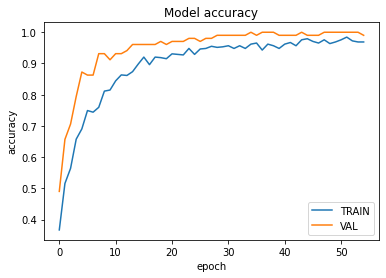

In [22]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [23]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

 1/14 [=>............................] - ETA: 0s - loss: 0.0301 - accuracy: 1.0000

14/14 [==============================] - 0s 3ms/step - loss: 0.0335 - accuracy: 0.9953


### Draw the confusion matrix to better understand the model performance

Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

       chair       1.00      1.00      1.00        84
       cobra       0.98      1.00      0.99        93
         dog       1.00      1.00      1.00        84
        tree       1.00      1.00      1.00        96
     warrior       1.00      0.97      0.99        68

    accuracy                           1.00       425
   macro avg       1.00      0.99      0.99       425
weighted avg       1.00      1.00      1.00       425



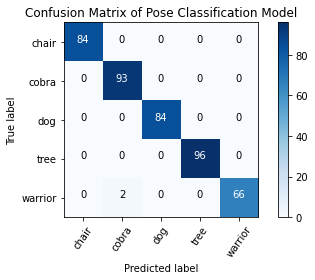

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

### (Optional) Investigate incorrect predictions

You can look at the poses from the `TEST` dataset that were incorrectly predicted to see whether the model accuracy can be improved.

Note: This only works if you have run step 1 because you need the pose image files on your local machine to display them.

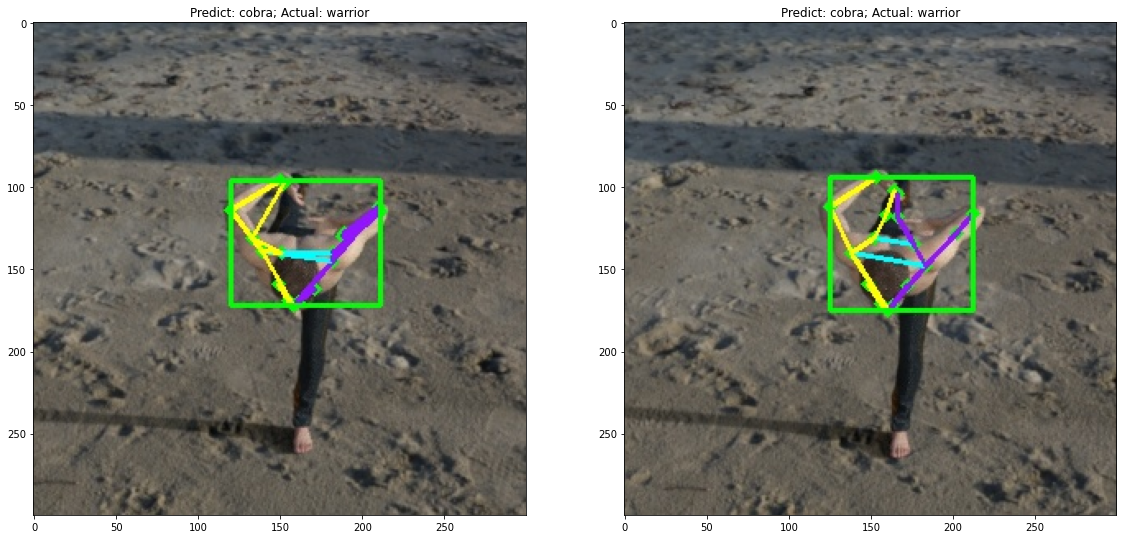

In [25]:
if is_skip_step_1:
  raise RuntimeError('You must have run step 1 to run this cell.')

# If step 1 was skipped, skip this step.
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Part 3: Convert the pose classification model to TensorFlow Lite

You'll convert the Keras pose classification model to the TensorFlow Lite format so that you can deploy it to mobile apps, web browsers and edge devices. When converting the model, you'll apply [dynamic range quantization](https://www.tensorflow.org/lite/performance/post_training_quant) to reduce the pose classification TensorFlow Lite model size by about 4 times with insignificant accuracy loss.

Note: TensorFlow Lite supports multiple quantization schemes. See the [documentation](https://www.tensorflow.org/lite/performance/model_optimization) if you are interested to learn more.

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

2022-03-31 11:11:52.506926: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpdr3gzjdb/assets


2022-03-31 11:11:54.032966: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-31 11:11:54.033032: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


Model size: 26KB


Then you'll write the label file which contains mapping from the class indexes to the human readable class names.

In [27]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

As you've applied quantization to reduce the model size, let's evaluate the quantized TFLite model to check whether the accuracy drop is acceptable.

In [28]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.9976470588235294


Now you can download the TFLite model (`pose_classifier.tflite`) and the label file (`pose_labels.txt`) to classify custom poses. See the [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/android) and [Python/Raspberry Pi](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) sample app for an end-to-end example of how to use the TFLite pose classification model.

In [29]:
!zip pose_classifier.zip pose_labels.txt pose_classifier.tflite

  adding: pose_labels.txt (stored 0%)
  adding: pose_classifier.tflite (deflated 35%)


In [30]:
# Download the zip archive if running on Colab.
try:
  from google.colab import files
  files.download('pose_classifier.zip')
except:
  pass